<a href="https://colab.research.google.com/github/DanijelaDaca/Analiza-drustvenih-mreza--Analiza-tvitova-o-Evroviziji/blob/main/AnalizaEvrovizijaTvitova.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
# Colab setup
!pip -q install pandas pyarrow nltk networkx

import nltk
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [67]:
# === 01_load_normalize_filter_en.py ===
import os, json, ast, re
import pandas as pd

RAW_DIR  = "data_raw"
PROC_DIR = "data_processed"
os.makedirs(RAW_DIR, exist_ok=True)
os.makedirs(PROC_DIR, exist_ok=True)

from google.colab import files
print("Izaberi svoj JSON/JSONL fajl (npr. 'Eurovision')…")
up = files.upload()
raw_path = list(up.keys())[0]

def load_any_json(path):
    rows=[]
    with open(path,'r',encoding='utf-8') as f:
        txt=f.read().strip()
        if '\n{' in txt:   # JSONL
            f.seek(0)
            for line in f:
                line=line.strip().rstrip(',')
                if not line: continue
                try: rows.append(json.loads(line))
                except: pass
        else:               # JSON lista ili jedan objekat
            obj=json.loads(txt)
            rows = obj if isinstance(obj,list) else [obj]
    return rows

raw = load_any_json(raw_path)
print("Sirovih zapisa:", len(raw))

def uinfo(u):
    if not u: return None, None
    return (u.get("id_str") or (str(u.get("id")) if u.get("id") is not None else None),
            u.get("screen_name"))

norm=[]
for tw in raw:
    uid, uname = uinfo(tw.get("user"))
    rid, runame = (None, None)
    if "retweeted_status" in tw:
        rid, runame = uinfo(tw["retweeted_status"].get("user"))

    mentions = [m.get("screen_name") for m in (tw.get("entities", {}) or {}).get("user_mentions", []) if m.get("screen_name")]

    norm.append({
        "tweet_id": tw.get("id_str") or str(tw.get("id")),
        "created_at": tw.get("created_at"),
        "lang": tw.get("lang"),
        "text": tw.get("text"),
        "user_id": uid,
        "username": uname,
        "retweeted_user_id": rid,
        "retweeted_username": runame,
        "in_reply_to_user_id": tw.get("in_reply_to_user_id_str") or (str(tw.get("in_reply_to_user_id")) if tw.get("in_reply_to_user_id") is not None else None),
        "in_reply_to_screen_name": tw.get("in_reply_to_screen_name"),
        "is_retweet": "retweeted_status" in tw,
        "mentions": mentions,
    })

df = pd.DataFrame(norm)
df_en = df[df["lang"]=="en"].copy()
print("Engleski tvitovi:", len(df_en))

out_parquet = os.path.join(PROC_DIR, "tweets_en.parquet")
df_en.to_parquet(out_parquet, index=False)
print("✔ Sačuvano:", out_parquet)


Izaberi svoj JSON/JSONL fajl (npr. 'Eurovision')…


Saving Drugo semi finale.json to Drugo semi finale (4).json
Sirovih zapisa: 536
Engleski tvitovi: 204
✔ Sačuvano: data_processed/tweets_en.parquet


In [68]:
# === 02_build_nodes_edges.py (robust) ===
import os, ast, numpy as np, pandas as pd

PROC_DIR = "data_processed"
os.makedirs(PROC_DIR, exist_ok=True)

df = pd.read_parquet(os.path.join(PROC_DIR, "tweets_en.parquet")).copy()

# -------- helperi --------
def to_bool(x):
    # is_retweet ume da bude True/False, 1/0, "true"/"false", "True"/"False", None...
    if isinstance(x, bool): return x
    if pd.isna(x): return False
    s = str(x).strip().lower()
    return s in {"1","true","t","yes","y"}

def norm_mentions(val):
    """Vrati listu @user imena (bez '@'). Podržava list/tuple/set/np.ndarray/string/None."""
    if val is None: return []
    if isinstance(val, float) and pd.isna(val): return []
    if isinstance(val, (list, tuple, set)):
        return [str(x).strip().lstrip('@') for x in val if str(x).strip()]
    if isinstance(val, np.ndarray):
        return [str(x).strip().lstrip('@') for x in val.tolist() if str(x).strip()]
    if isinstance(val, str):
        # pokušaj literal_eval (ako je string lista), inače split po zarezu/blanko
        try:
            p = ast.literal_eval(val)
            if isinstance(p, (list, tuple, set)):
                return [str(x).strip().lstrip('@') for x in p if str(x).strip()]
        except Exception:
            pass
        parts = [p for p in re_split(val) if p]
        return [p.lstrip('@') for p in parts]
    return []

def re_split(s):
    # robust split za "a, b" ili "a b" ili "['a','b']" varijante
    return [t.strip() for t in s.replace(';',',').replace('|',',').replace('  ',' ').replace('\t',' ').split(',') if t.strip()]

def node_key(username, user_id):
    """Preferiraj username, fallback na pseudo-id."""
    if pd.notna(username) and str(username).strip():
        return str(username).strip()
    if pd.notna(user_id) and str(user_id).strip():
        return f"id:{user_id}"
    return None

# -------- normalizacije kolona --------
# is_retweet
if "is_retweet" in df.columns:
    df["is_retweet"] = df["is_retweet"].apply(to_bool)
else:
    df["is_retweet"] = False

# mentions
if "mentions" not in df.columns:
    df["mentions"] = [[] for _ in range(len(df))]
df["mentions"] = df["mentions"].apply(norm_mentions)

# in_reply_to_*
for c in ["in_reply_to_screen_name", "in_reply_to_user_id"]:
    if c not in df.columns:
        df[c] = np.nan

# retweeted_*
for c in ["retweeted_username", "retweeted_user_id"]:
    if c not in df.columns:
        df[c] = np.nan

# created_at -> ISO UTC string (kasnije 07 radi korektno)
df["created_at"] = pd.to_datetime(df.get("created_at"), utc=True, errors="coerce")
df["created_at_iso"] = df["created_at"].dt.strftime("%Y-%m-%dT%H:%M:%SZ")

# -------- nodes --------
users = {}
def add_user(username, user_id):
    k = node_key(username, user_id)
    if not k: return
    if k not in users:
        users[k] = {"node_id": k, "username": username, "user_id": user_id}

for _, r in df.iterrows():
    add_user(r.get("username"), r.get("user_id"))
for _, r in df[df["is_retweet"]].iterrows():
    add_user(r.get("retweeted_username"), r.get("retweeted_user_id"))
for ms in df["mentions"]:
    for u in ms:
        add_user(u, None)

nodes = pd.DataFrame(users.values(), columns=["node_id","username","user_id"])

# -------- edges (sirovo) --------
edges = []

# retweet: retweeter -> original
for _, r in df[df["is_retweet"]].iterrows():
    src = node_key(r.get("username"), r.get("user_id"))
    tgt = node_key(r.get("retweeted_username"), r.get("retweeted_user_id"))
    if src and tgt and src != tgt:
        edges.append([src, tgt, "retweet", r.get("tweet_id"), r.get("created_at_iso")])

# reply: autor -> kome odgovara
rp = df[df["in_reply_to_screen_name"].notna()]
for _, r in rp.iterrows():
    src = node_key(r.get("username"), r.get("user_id"))
    tgt = node_key(r.get("in_reply_to_screen_name"), r.get("in_reply_to_user_id"))
    if src and tgt and src != tgt:
        edges.append([src, tgt, "reply", r.get("tweet_id"), r.get("created_at_iso")])

# mention: autor -> svaki mention
for _, r in df.iterrows():
    src = node_key(r.get("username"), r.get("user_id"))
    if not src:
        continue
    for m in r["mentions"]:
        tgt = node_key(m, None)
        if tgt and src != tgt:
            edges.append([src, tgt, "mention", r.get("tweet_id"), r.get("created_at_iso")])

edges = pd.DataFrame(edges, columns=["source","target","edge_type","tweet_id","created_at"])
# ukloni moguće NaN source/target
edges = edges.dropna(subset=["source","target"]).copy()

# -------- agregacija (ponderisane ivice) --------
edges_w = (edges
           .groupby(["source","target","edge_type"], as_index=False)
           .agg(weight=("tweet_id","count"),
                first_ts=("created_at","min"),
                last_ts=("created_at","max")))

# -------- snimanja --------
nodes.to_csv(os.path.join(PROC_DIR,"nodes.csv"), index=False)
edges.to_csv(os.path.join(PROC_DIR,"edges.csv"), index=False)             # sirove ivice (svaki tvit = jedna ivica)
edges_w.to_csv(os.path.join(PROC_DIR,"edges_weighted.csv"), index=False)  # agregirane ivice

# per-tip fajlovi (korisno za 05)
for et in ["retweet","reply","mention"]:
    edges_w[edges_w["edge_type"]==et].to_csv(os.path.join(PROC_DIR, f"edges_{et}.csv"), index=False)

# -------- statistika --------
n_nodes = len(nodes)
n_edges = len(edges)
n_edges_w = len(edges_w)
by_type = edges_w.groupby("edge_type")["weight"].sum().to_dict()

print("✔ Sačuvano:")
print("  - data_processed/nodes.csv")
print("  - data_processed/edges.csv (sirovo)")
print("  - data_processed/edges_weighted.csv (agregat)")
print("  - data_processed/edges_retweet.csv / edges_reply.csv / edges_mention.csv")
print(f"Stats: nodes={n_nodes}  edges_raw={n_edges}  edges_weighted={n_edges_w}  weights_by_type={by_type}")
print("Kolone edges:", list(edges.columns))


✔ Sačuvano:
  - data_processed/nodes.csv
  - data_processed/edges.csv (sirovo)
  - data_processed/edges_weighted.csv (agregat)
  - data_processed/edges_retweet.csv / edges_reply.csv / edges_mention.csv
Stats: nodes=288  edges_raw=292  edges_weighted=282  weights_by_type={'mention': 185, 'reply': 15, 'retweet': 92}
Kolone edges: ['source', 'target', 'edge_type', 'tweet_id', 'created_at']


/tmp/ipython-input-3138425376.py:72: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["created_at"] = pd.to_datetime(df.get("created_at"), utc=True, errors="coerce")


Graph → nodes: 288  edges: 179

Top 10 korisnika po degree:
 1. Eurovision           degree=16.0000
 2. RichardAArnold       degree=8.0000
 3. Socialistdawn        degree=8.0000
 4. SaaraAaltoSP         degree=6.0000
 5. TuomikoskiElina      degree=6.0000
 6. justonekoala         degree=6.0000
 7. Stingraytwo          degree=5.0000
 8. bbceurovision        degree=5.0000
 9. Rylan                degree=5.0000
10. Montevizija          degree=4.0000

Top 10 korisnika po betweenness:
 1. Eurovision           betweenness=0.0343
 2. Stingraytwo          betweenness=0.0157
 3. RichardAArnold       betweenness=0.0106
 4. coolisraelit         betweenness=0.0076
 5. bbceurovision        betweenness=0.0058
 6. NettaBarzilai        betweenness=0.0053
 7. SoniaHamidi1         betweenness=0.0052
 8. AlexanderRybak       betweenness=0.0040
 9. FoltaPatrycja        betweenness=0.0039
10. ElinaNechayeva       betweenness=0.0039

Top 10 korisnika po closeness:
 1. Eurovision           closeness=0.4130
 

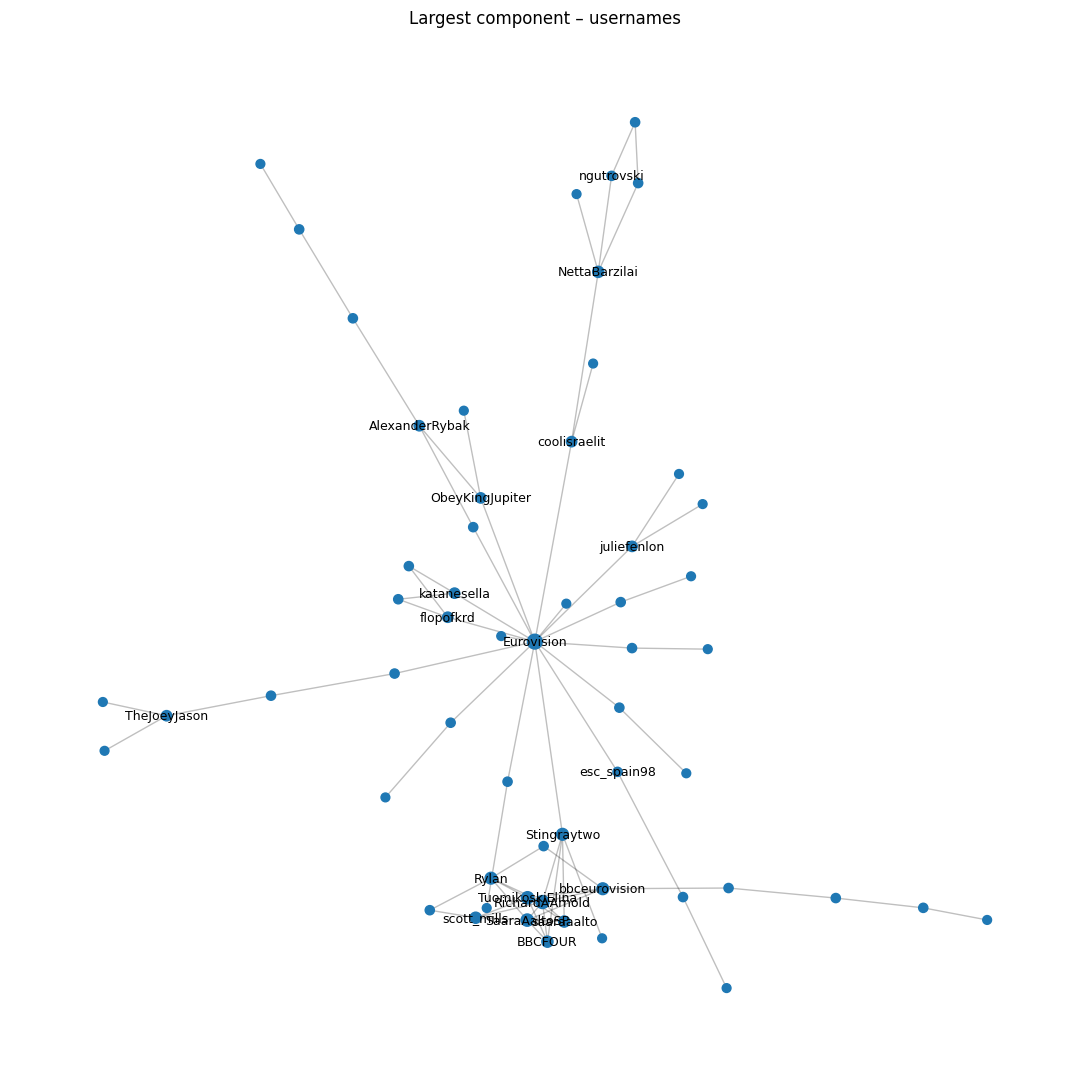

In [69]:
# === 03_networkx_quick.py (dopunjeno sa top 10 centralnostima) ===
import os, math, pandas as pd, networkx as nx, matplotlib.pyplot as plt

PROC_DIR = "data_processed"
FIG_DIR  = "figures"; os.makedirs(FIG_DIR, exist_ok=True)

nodes = pd.read_csv(os.path.join(PROC_DIR,"nodes.csv"), dtype=str)
edges = pd.read_csv(os.path.join(PROC_DIR,"edges.csv"), dtype=str)

G = nx.DiGraph()
for _, r in nodes.iterrows():
    G.add_node(r["node_id"], username=r.get("username"), user_id=r.get("user_id"))

for _, r in edges.iterrows():
    if r["source"] and r["target"]:
        G.add_edge(r["source"], r["target"], edge_type=r["edge_type"])

print(f"Graph → nodes: {G.number_of_nodes()}  edges: {G.number_of_edges()}")

UG = G.to_undirected()
deg = dict(UG.degree())
bet = nx.betweenness_centrality(UG, normalized=True)
if UG.number_of_nodes()>0:
    giant = max(nx.connected_components(UG), key=len)
    H = UG.subgraph(giant).copy()
    clos = nx.closeness_centrality(H)
    closeness = {n: clos.get(n,0.0) for n in UG.nodes()}
else:
    closeness = {n:0.0 for n in UG.nodes()}

nx.set_node_attributes(G, deg, "degree")
nx.set_node_attributes(G, bet, "betweenness")
nx.set_node_attributes(G, closeness, "closeness")

# === Top 10 po centralnostima ===
def top10(metric_dict, label):
    top = sorted(metric_dict.items(), key=lambda x: x[1], reverse=True)[:10]
    print(f"\nTop 10 korisnika po {label}:")
    for i, (n, v) in enumerate(top, 1):
        uname = G.nodes[n].get("username") or n
        print(f"{i:2d}. {uname:20s} {label}={v:.4f}")

top10(deg, "degree")
top10(bet, "betweenness")
top10(closeness, "closeness")

# === Vizualizacija najveće komponente ===
plt.figure(figsize=(11,11))
if UG.number_of_nodes()>0:
    Hpos = nx.spring_layout(H, seed=42)
    sizes = [max(40, 40*math.log1p(dict(H.degree()).get(n,1))) for n in H.nodes()]
    nx.draw_networkx_nodes(H, Hpos, node_size=sizes)
    nx.draw_networkx_edges(H, Hpos, alpha=0.25)
    top = sorted(dict(H.degree()).items(), key=lambda x:x[1], reverse=True)[:20]
    labels = {n: (G.nodes[n].get("username") or n) for n,_ in top}
    nx.draw_networkx_labels(H, Hpos, labels=labels, font_size=9)
    plt.title("Largest component – usernames")
    plt.axis("off"); plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR,"largest_component_usernames.png"), dpi=160)
    plt.show()


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


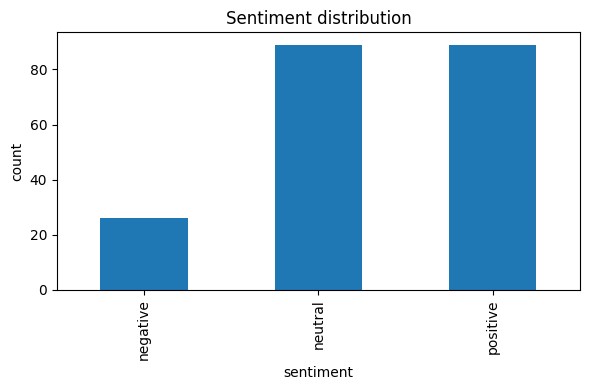

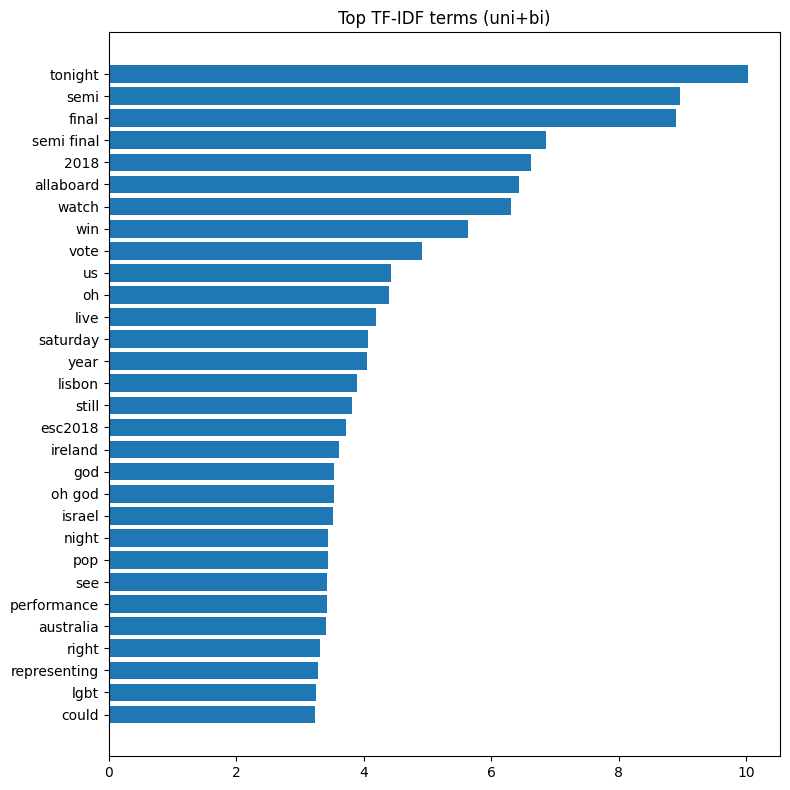

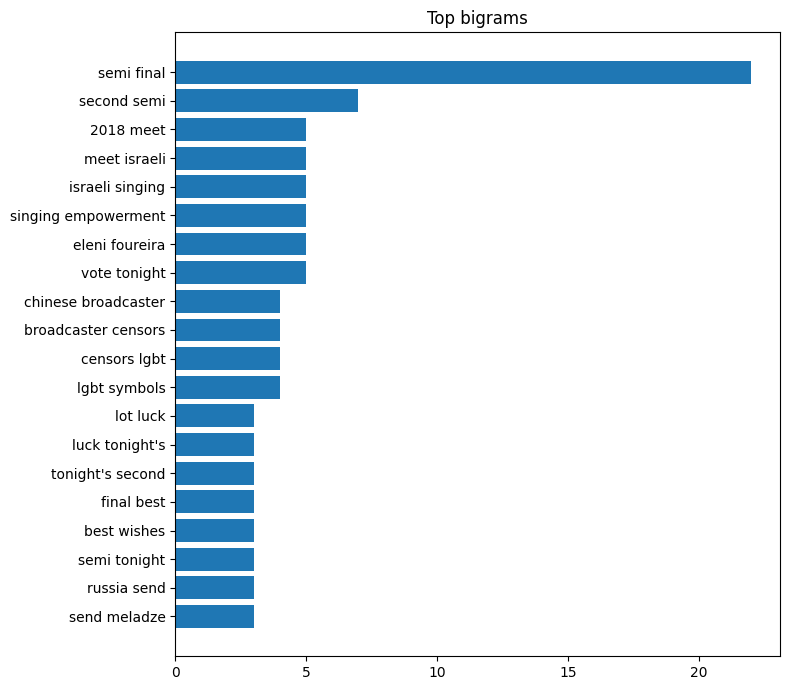

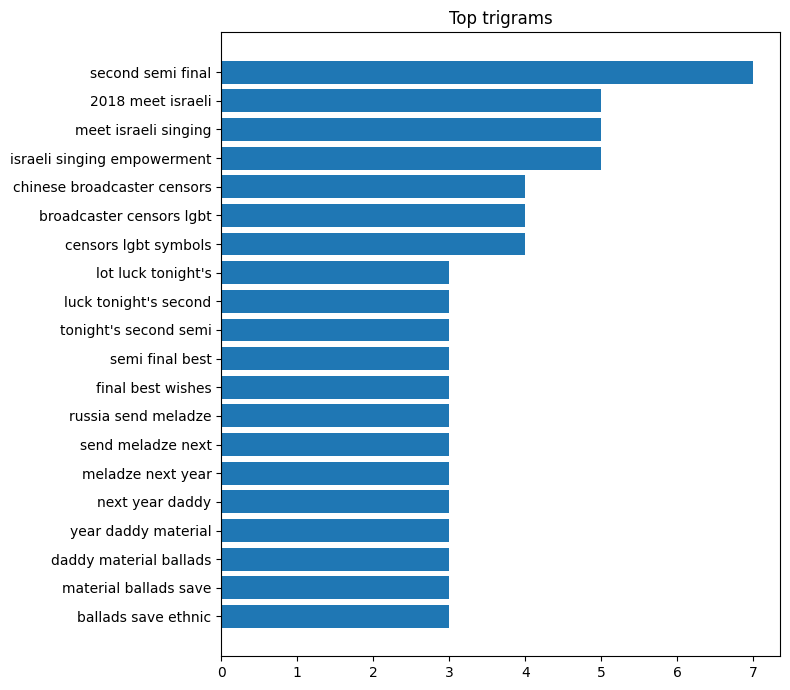

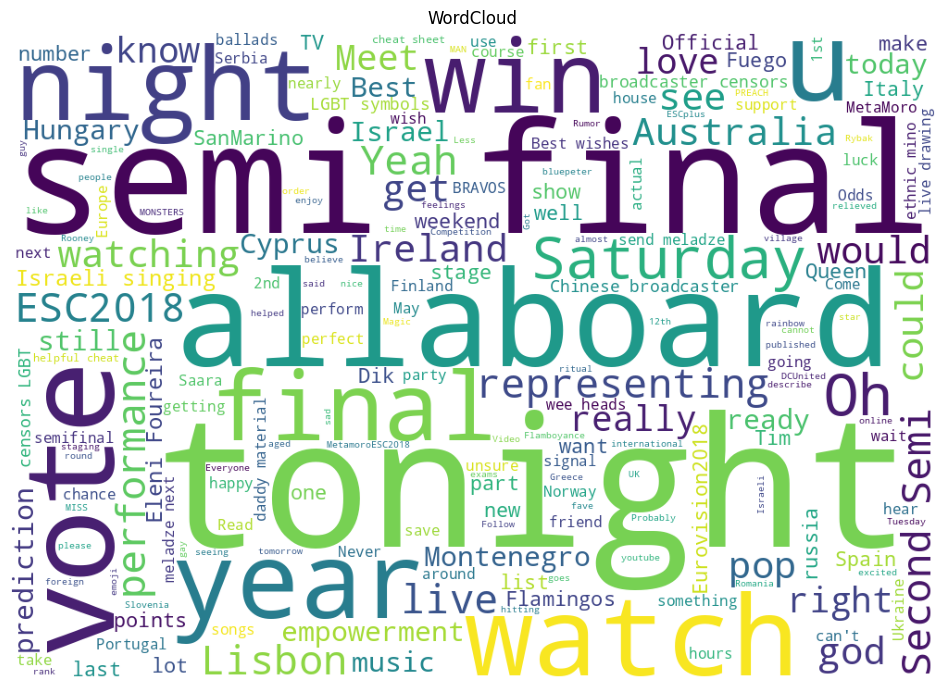

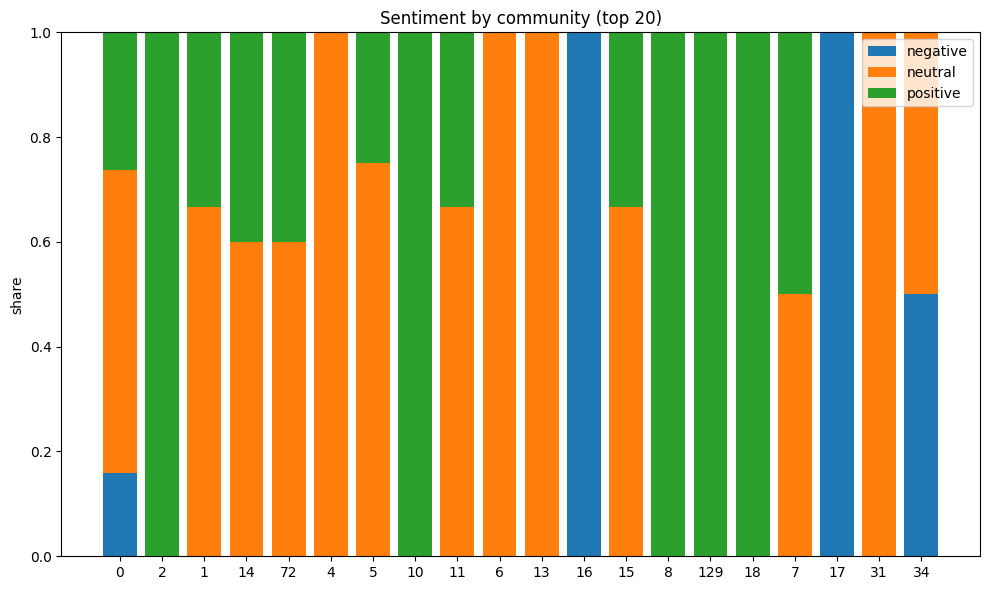

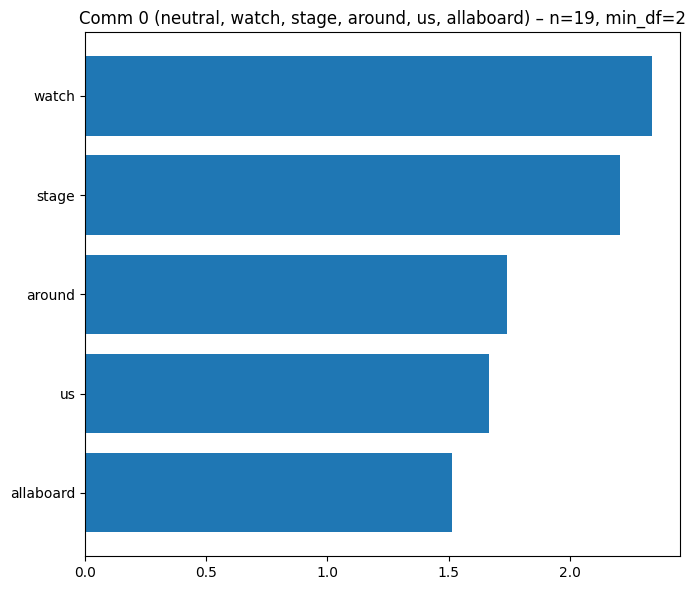

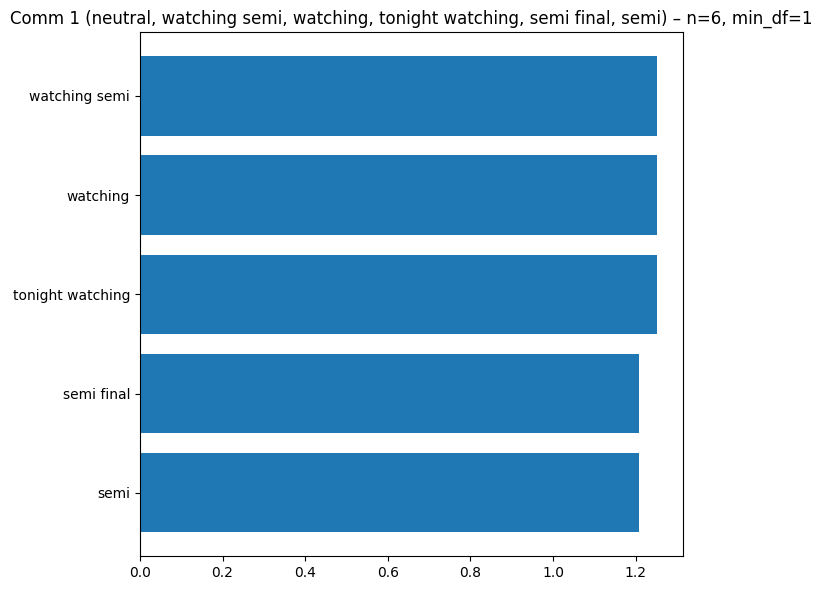

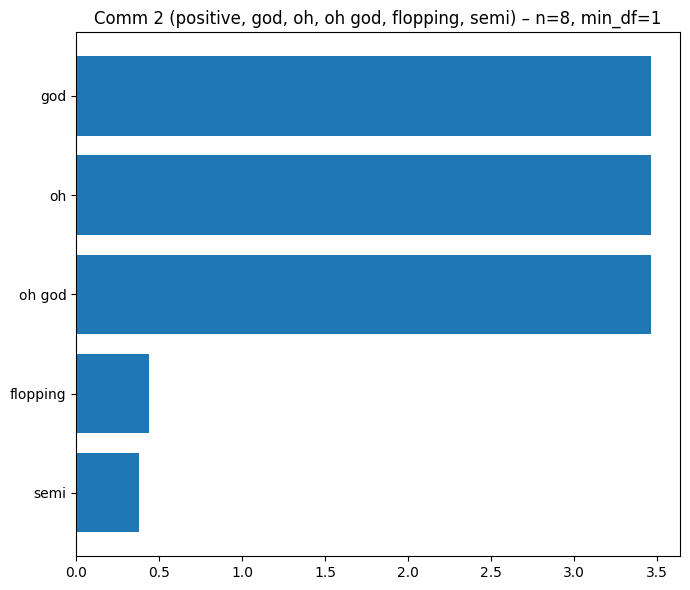

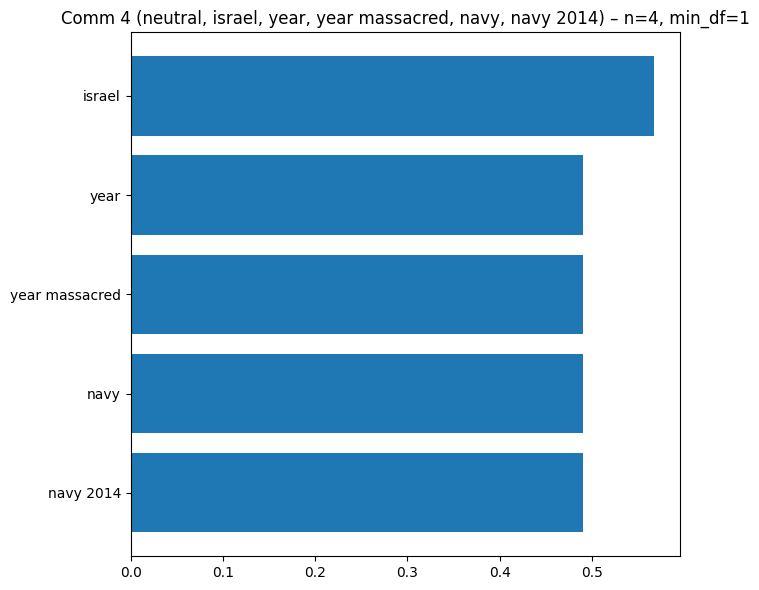

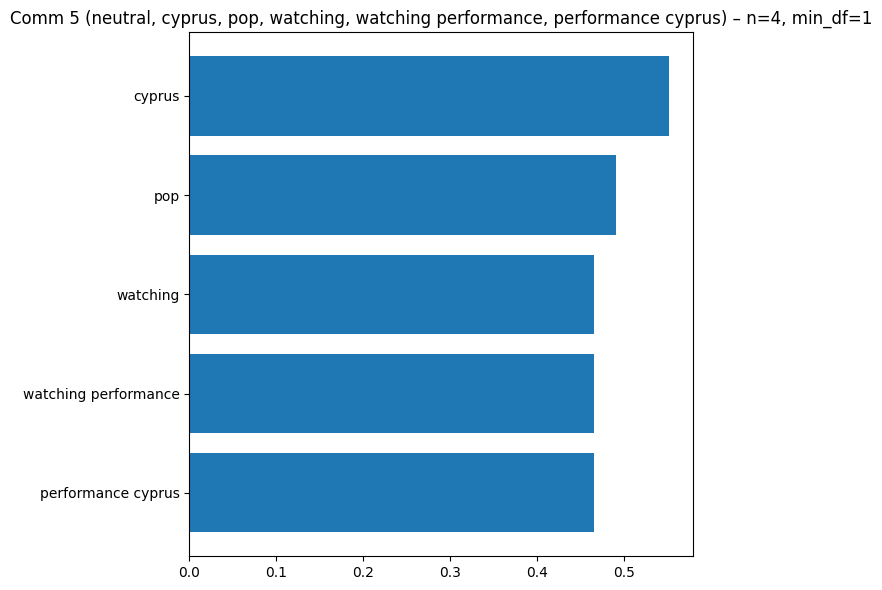

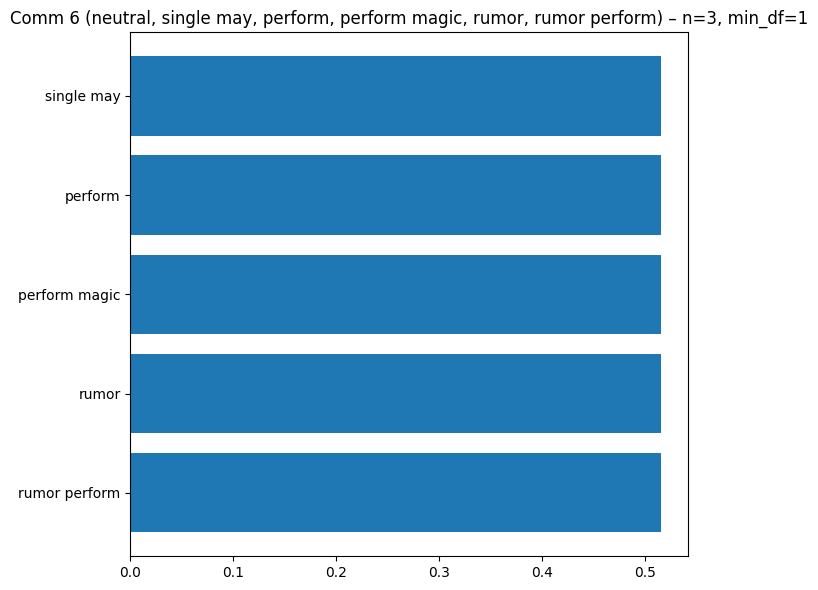

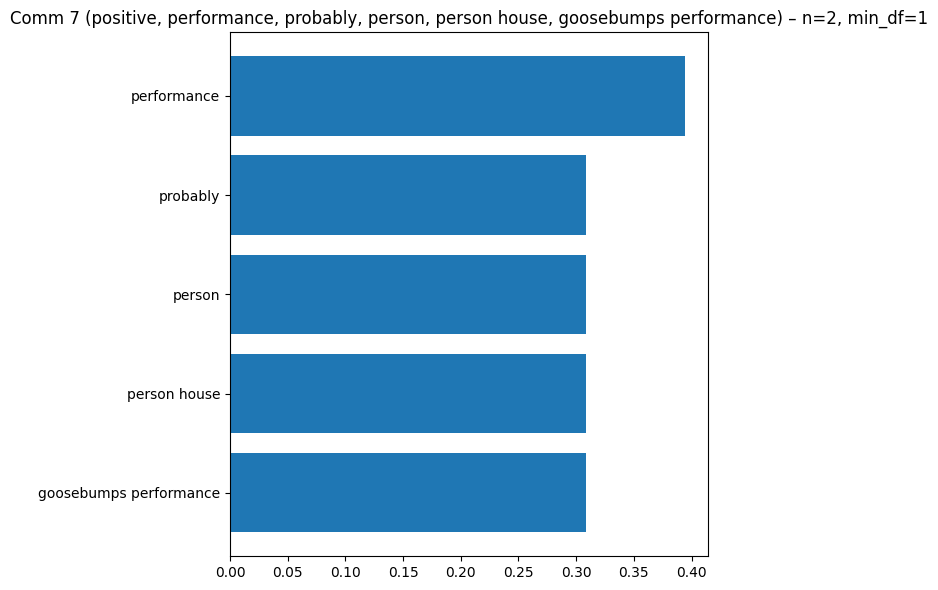

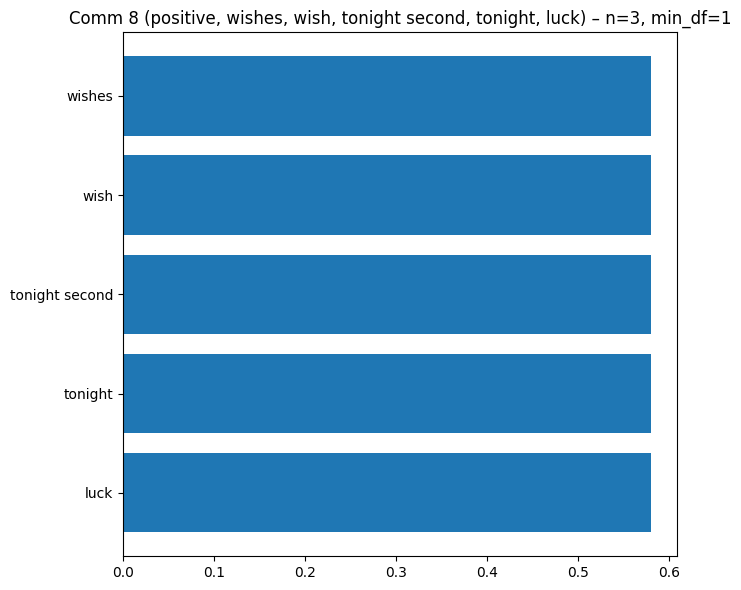

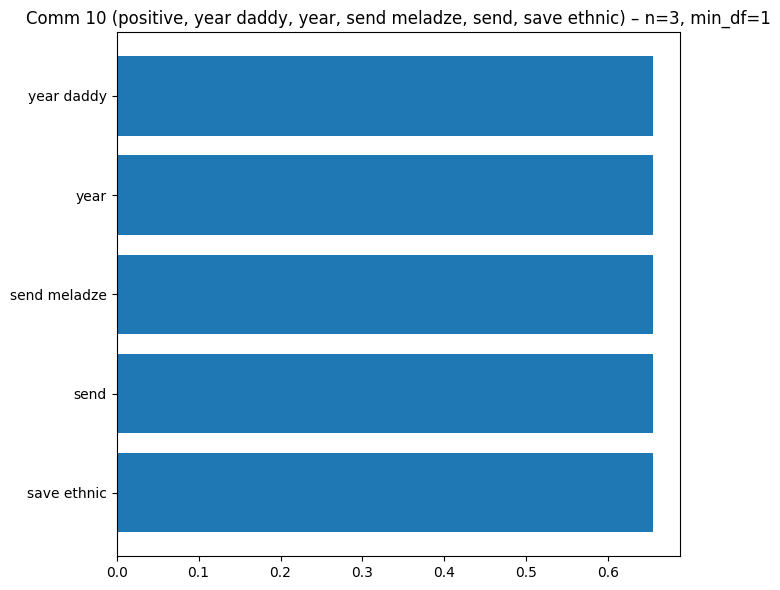

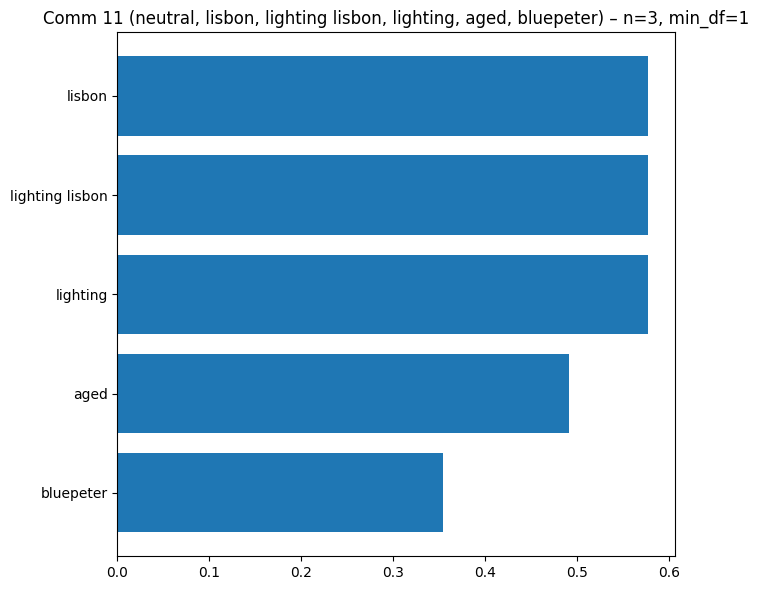

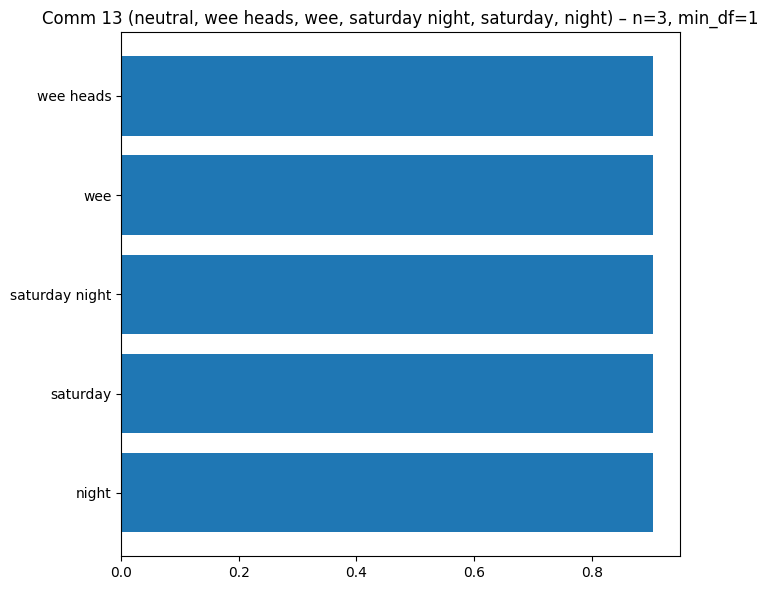

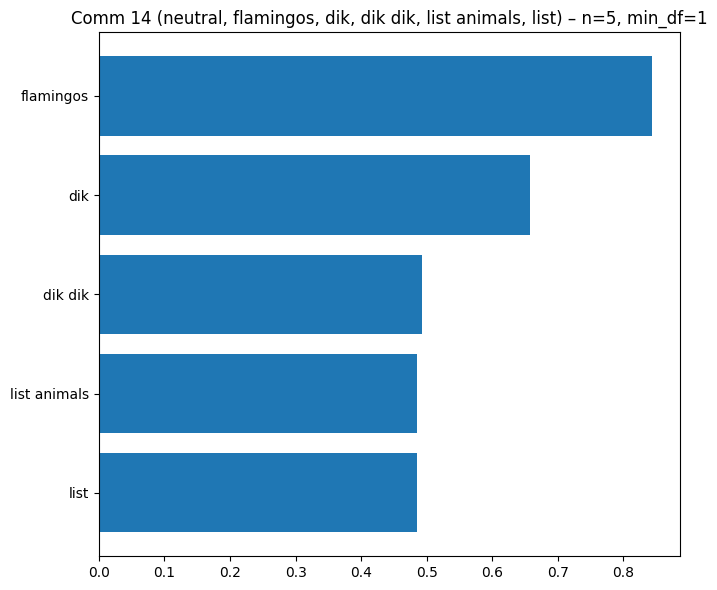

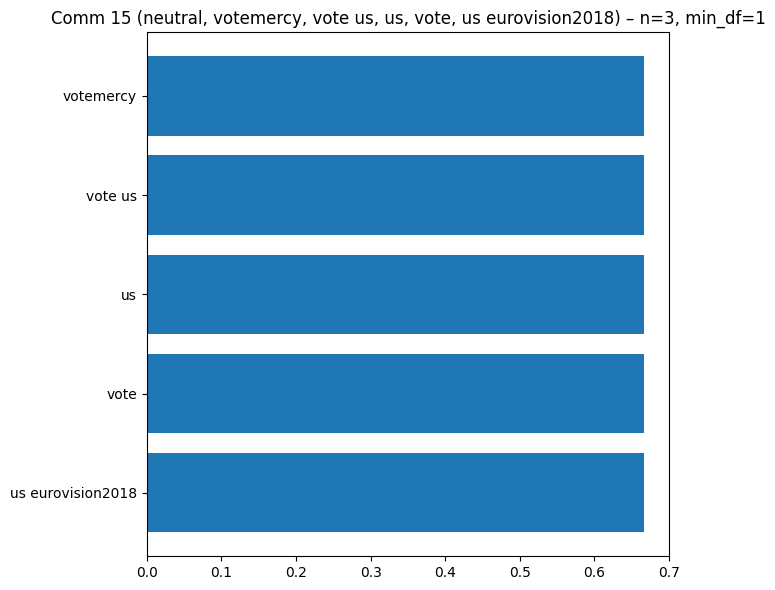

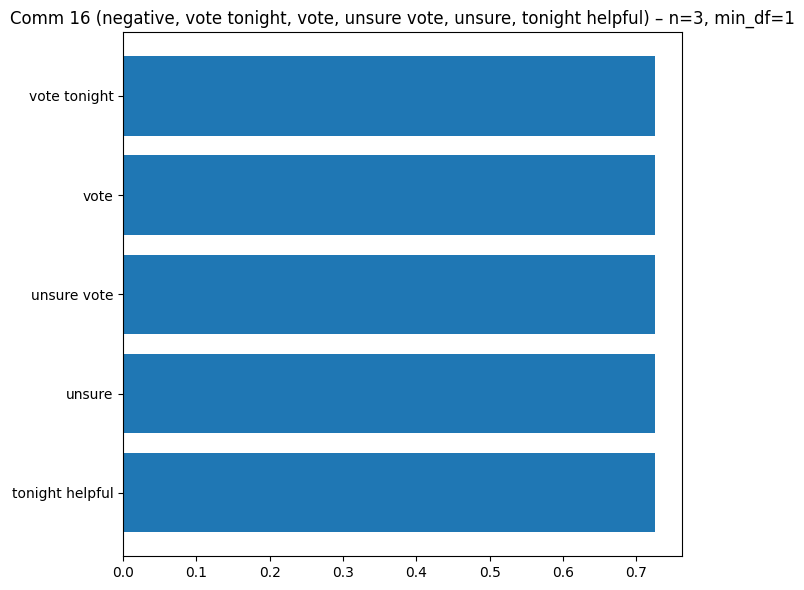

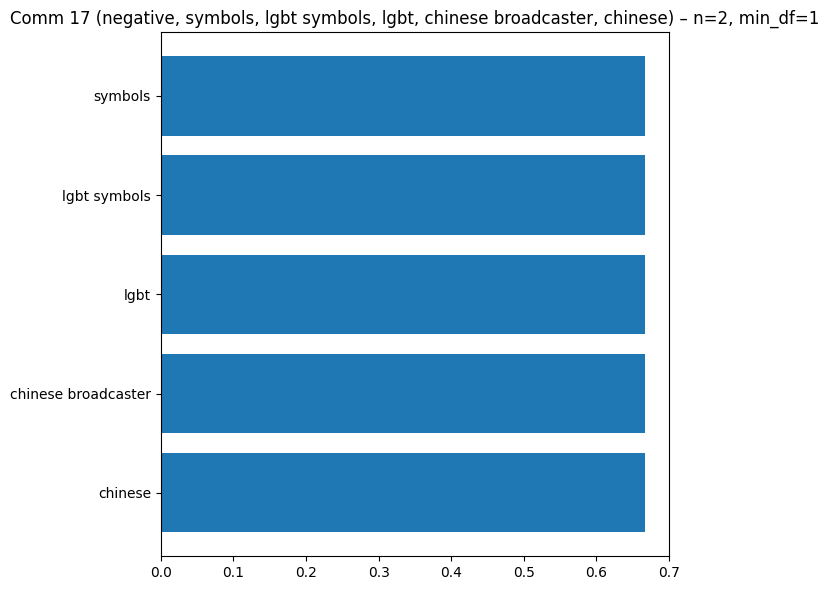

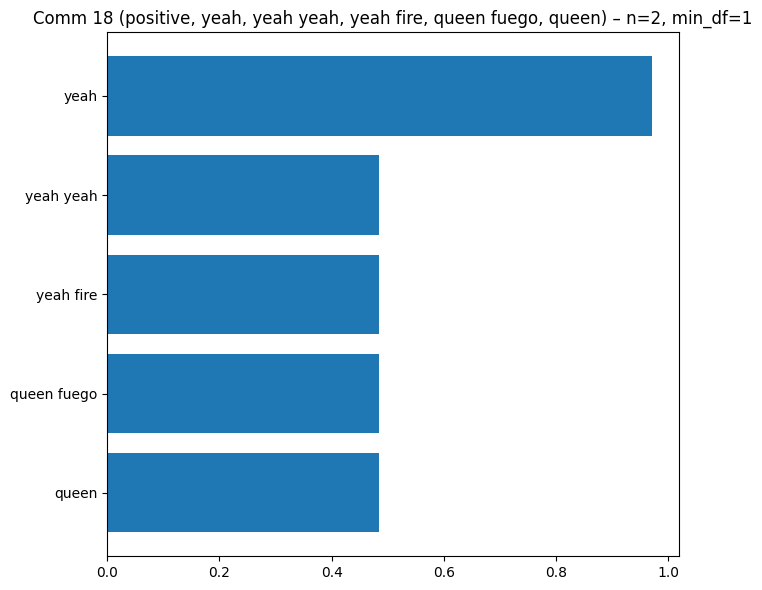

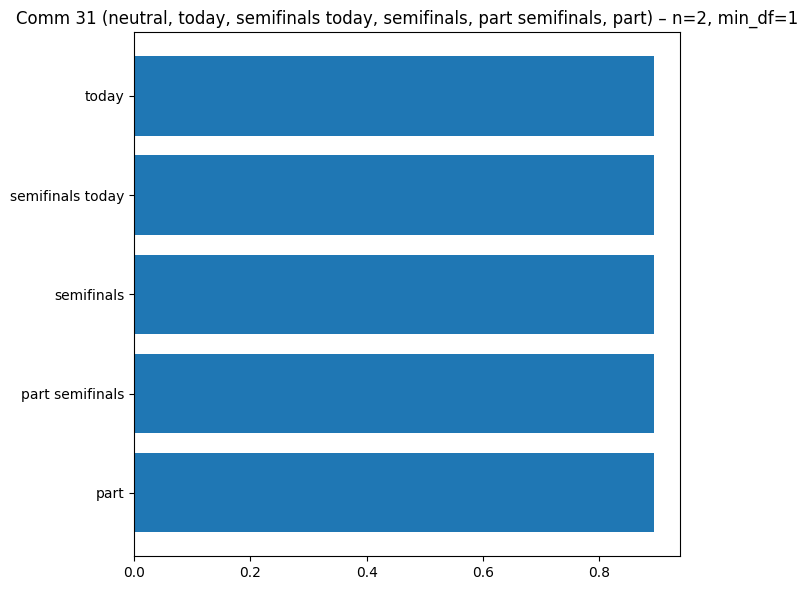

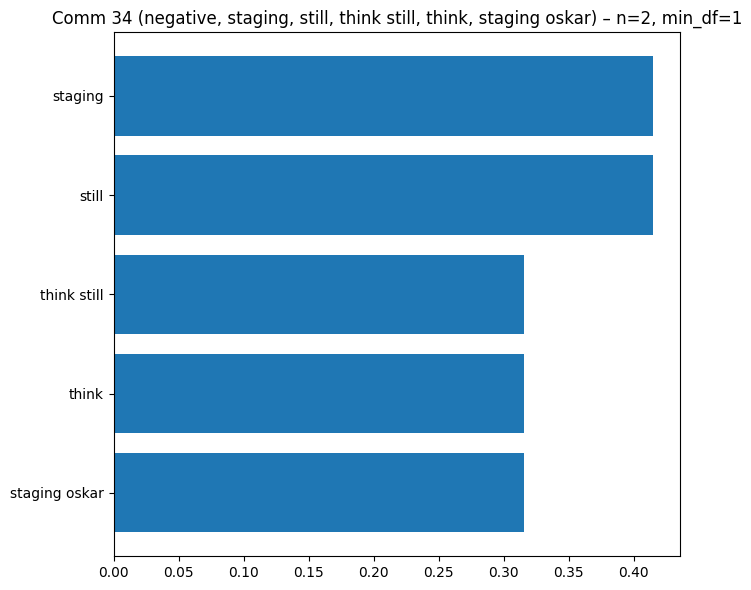

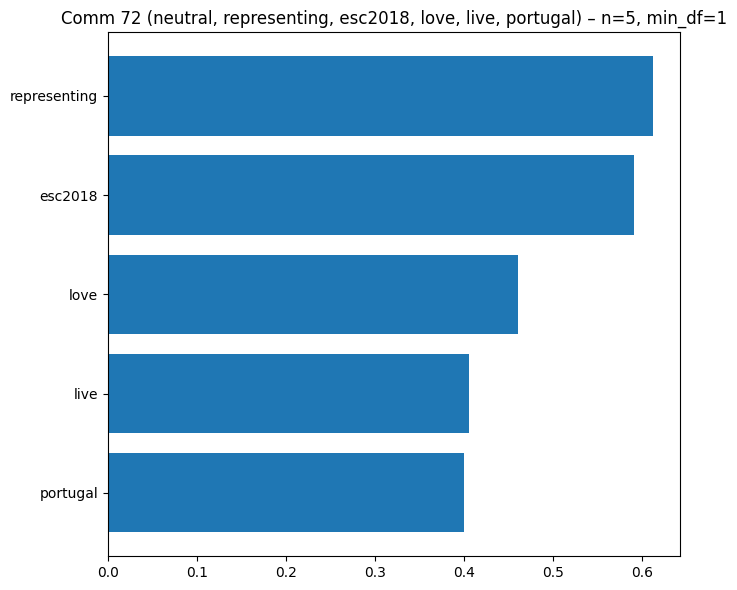

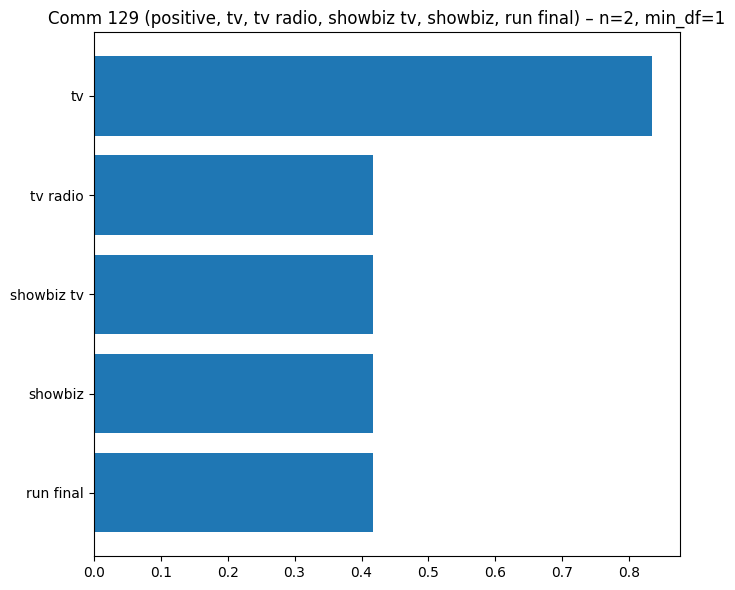

✔ 04/04C završeno. Rezultati su u data_processed/ i figures/


In [70]:
# === 04_content_analysis_and_communities.py ===
!pip -q install nltk scikit-learn wordcloud

import os, re, numpy as np, pandas as pd, matplotlib.pyplot as plt
from collections import Counter
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download("vader_lexicon"); nltk.download("stopwords")
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

PROC_DIR, FIG_DIR = "data_processed", "figures"
os.makedirs(PROC_DIR, exist_ok=True); os.makedirs(FIG_DIR, exist_ok=True)

# ---------------- 1) UČITAJ TVITOVE ----------------
df = pd.read_parquet(os.path.join(PROC_DIR, "tweets_en.parquet")).copy()

# ---------------- 2) ČIŠĆENJE TEKSTA ----------------
def clean(txt: str) -> str:
    t = txt or ""
    t = re.sub(r"http\S+"," ", t)
    t = re.sub(r"@[A-Za-z0-9_]+"," ", t)
    t = re.sub(r"#"," ", t)
    t = re.sub(r"[^A-Za-z0-9\s']+"," ", t)
    t = re.sub(r"\s+"," ", t).strip()
    return t

df["clean_text"] = df["text"].astype(str).apply(clean)

# ---------------- 3) SENTIMENT (CEO KORPUS) ----------------
sia = SentimentIntensityAnalyzer()
sent_scores = df["clean_text"].apply(sia.polarity_scores).apply(pd.Series)

def lab(comp):
    if comp >= 0.05: return "positive"
    if comp <= -0.05: return "negative"
    return "neutral"

df_sent = pd.concat([df[["tweet_id","created_at","username","clean_text"]], sent_scores], axis=1)
df_sent["sentiment"] = df_sent["compound"].apply(lab)
df_sent.to_csv(os.path.join(PROC_DIR, "sentiment_results.csv"), index=False)

plt.figure(figsize=(6,4))
df_sent["sentiment"].value_counts().reindex(["negative","neutral","positive"]).plot(kind="bar")
plt.title("Sentiment distribution"); plt.ylabel("count"); plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "sentiment_distribution.png"), dpi=160); plt.show()

# ---------------- 4) TF-IDF (uni+bi) + NGrami ----------------
stop_en = set(stopwords.words("english"))
stop_en.update(["eurovision","esc","song","contest","rt","amp","im","ive","dont"])
stop_list = list(stop_en)

# TF-IDF
if df["clean_text"].str.strip().eq("").all():
    tfidf_df = pd.DataFrame(columns=["term","score"])
else:
    vec = TfidfVectorizer(lowercase=True, stop_words=stop_list, ngram_range=(1,2), min_df=3)
    X = vec.fit_transform(df["clean_text"])
    terms = np.array(vec.get_feature_names_out())
    scores = np.asarray(X.sum(axis=0)).ravel()
    top_idx = scores.argsort()[::-1][:30]
    tfidf_df = pd.DataFrame({"term": terms[top_idx], "score": scores[top_idx]})
tfidf_df.to_csv(os.path.join(PROC_DIR, "top_tfidf_terms.csv"), index=False)

if len(tfidf_df):
    plt.figure(figsize=(8,8))
    plt.barh(tfidf_df["term"][::-1], tfidf_df["score"][::-1])
    plt.title("Top TF-IDF terms (uni+bi)"); plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, "top_tfidf_terms.png"), dpi=160); plt.show()

# NGram helper
def ngrams(tok_list, n=2):
    return [" ".join(tok_list[i:i+n]) for i in range(len(tok_list)-n+1)]

# tokeni (bez stop reči)
tokens = []
for t in df["clean_text"]:
    toks = [w for w in t.lower().split() if w not in stop_en and len(w)>2]
    tokens.extend(toks)

# BIGRAMS
bigram_cnt = Counter(ngrams(tokens, 2))
bi_top = bigram_cnt.most_common(20)
if bi_top:
    bi_labels, bi_vals = list(zip(*bi_top))
    plt.figure(figsize=(8,7))
    plt.barh(list(bi_labels)[::-1], list(bi_vals)[::-1])
    plt.title("Top bigrams"); plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, "top_bigrams.png"), dpi=160); plt.show()
pd.DataFrame(bi_top, columns=["bigram","count"]).to_csv(os.path.join(PROC_DIR,"top_bigrams.csv"), index=False)

# TRIGRAMS
trigram_cnt = Counter(ngrams(tokens, 3))
tri_top = trigram_cnt.most_common(20)
if tri_top:
    tri_labels, tri_vals = list(zip(*tri_top))
    plt.figure(figsize=(8,7))
    plt.barh(list(tri_labels)[::-1], list(tri_vals)[::-1])
    plt.title("Top trigrams"); plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, "top_trigrams.png"), dpi=160); plt.show()
pd.DataFrame(tri_top, columns=["trigram","count"]).to_csv(os.path.join(PROC_DIR,"top_trigrams.csv"), index=False)

# WordCloud
txt_wc = " ".join(df["clean_text"].tolist())
if txt_wc.strip():
    wc = WordCloud(width=1000, height=700, stopwords=stop_en, background_color="white").generate(txt_wc)
    plt.figure(figsize=(10,7)); plt.imshow(wc); plt.axis("off"); plt.title("WordCloud"); plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, "wordcloud.png"), dpi=160); plt.show()

# ---------------- 5) MAPIRANJE COMMUNITY NA TVITOVE (za 04C/06+) ----------------
nm_path = os.path.join(PROC_DIR, "nodes_metrics.csv")
if os.path.exists(nm_path):
    nm = pd.read_csv(nm_path, dtype={"node":str})
    # mapiramo community preko usernamena (fallback na node_id)
    user2comm = dict(zip(nm["username"].fillna(nm["node"]), nm["community"]))
    df_comm = df.copy()
    df_comm["community"] = df_comm["username"].map(user2comm)
    df_comm.to_parquet(os.path.join(PROC_DIR,"tweets_en_with_community.parquet"), index=False)
else:
    print("Upozorenje: nema data_processed/nodes_metrics.csv → 04C deo će se preskočiti.")

# ---------------- 6) 04C: SENTIMENT + TF-IDF PO ZAJEDNICAMA (TOP_K) ----------------
if os.path.exists(nm_path):
    tweets = pd.read_parquet(os.path.join(PROC_DIR,"tweets_en_with_community.parquet")).copy()
    tweets = tweets.dropna(subset=["community"]).copy()
    tweets["community"] = tweets["community"].astype(int)

    # sentiment po tvitu
    sc2 = tweets["clean_text"].apply(sia.polarity_scores).apply(pd.Series)
    tw = pd.concat([tweets, sc2], axis=1)
    tw["sentiment"] = tw["compound"].apply(lab)
    tw[["tweet_id","created_at","username","community","clean_text","pos","neu","neg","compound","sentiment"]] \
        .to_csv(os.path.join(PROC_DIR,"sentiment_by_community.csv"), index=False)

    # rezime zajednica
    sent_summary = (tw.groupby(["community","sentiment"]).size()
                    .unstack(fill_value=0).reset_index())
    for col in ["negative","neutral","positive"]:
        if col not in sent_summary.columns: sent_summary[col] = 0
    sent_summary["total"] = sent_summary[["negative","neutral","positive"]].sum(axis=1)
    for col in ["negative","neutral","positive"]:
        sent_summary[f"{col}_pct"] = (sent_summary[col] / sent_summary["total"]).round(3)
    sent_summary = sent_summary.merge(
        tw.groupby("community")["compound"].mean().round(3).rename("compound_mean"),
        on="community", how="left"
    ).sort_values("total", ascending=False)
    sent_summary.to_csv(os.path.join(PROC_DIR,"sentiment_summary_by_community.csv"), index=False)

    # TOP_K zajednice po veličini
    TOP_K = 20
    top_comms = sent_summary.head(TOP_K)["community"].tolist()

    # stacked bar (share po sentimentu)
    top_df = sent_summary[sent_summary["community"].isin(top_comms)].copy().sort_values("total", ascending=False)
    plt.figure(figsize=(10,6))
    bottom = np.zeros(len(top_df))
    for col in ["negative","neutral","positive"]:
        plt.bar(top_df["community"].astype(str), top_df[f"{col}_pct"], bottom=bottom, label=col)
        bottom += top_df[f"{col}_pct"].values
    plt.title(f"Sentiment by community (top {TOP_K})"); plt.ylabel("share"); plt.legend()
    plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, f"sentiment_by_community_top{TOP_K}.png"), dpi=160); plt.show()

    # TF-IDF po zajednicama + automatske labele
    labels = []
    for cid, group in tw.groupby("community"):
        if cid not in top_comms:
            continue
        docs = group["clean_text"].astype(str)
        docs = docs[docs.str.strip()!=""]
        n_docs = len(docs)
        if n_docs == 0:
            continue
        # adaptivni min_df da ne puca na manjim skupovima
        min_df = 1 if n_docs < 10 else (2 if n_docs < 50 else 3)
        vec = TfidfVectorizer(lowercase=True, stop_words=stop_list, ngram_range=(1,2), min_df=min_df)
        X = vec.fit_transform(docs)
        terms = np.array(vec.get_feature_names_out())
        scores = np.asarray(X.sum(axis=0)).ravel()
        if scores.size == 0:
            continue
        top_idx = scores.argsort()[::-1][:5]
        keywords = ", ".join(terms[top_idx])
        dom_sent = group["sentiment"].value_counts().idxmax()
        comm_label = f"Comm {cid} ({dom_sent}, {keywords})"
        labels.append((cid, comm_label, n_docs, dom_sent, keywords))

        top_df_term = pd.DataFrame({"term": terms[top_idx], "score": scores[top_idx]})
        top_df_term.to_csv(os.path.join(PROC_DIR, f"tfidf_comm_{cid}.csv"), index=False)
        plt.figure(figsize=(7,6))
        plt.barh(top_df_term["term"][::-1], top_df_term["score"][::-1])
        plt.title(f"{comm_label} – n={n_docs}, min_df={min_df}")
        plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, f"tfidf_comm_{cid}.png"), dpi=160); plt.show()

    pd.DataFrame(labels, columns=["community","label","n_docs","dominant_sentiment","keywords"]) \
        .sort_values("n_docs", ascending=False) \
        .to_csv(os.path.join(PROC_DIR, f"community_labels_top{TOP_K}.csv"), index=False)

print("✔ 04/04C završeno. Rezultati su u data_processed/ i figures/")




retweet: nodes=149, edges=88


/tmp/ipython-input-3977018843.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.title(f"{etype.capitalize()} network"); plt.axis("off"); plt.tight_layout()


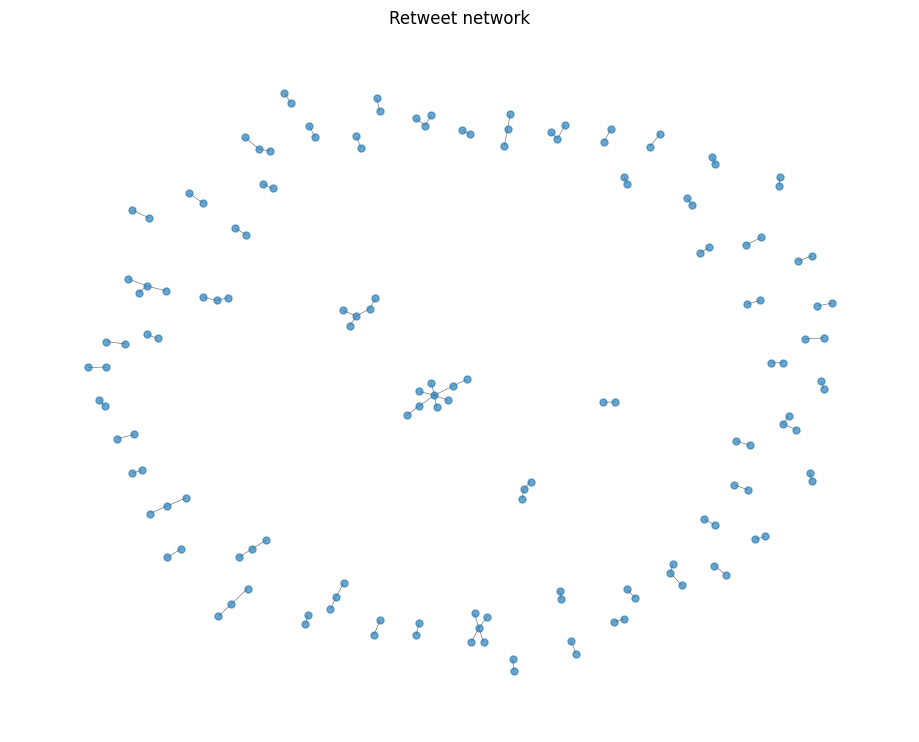

reply: nodes=27, edges=15


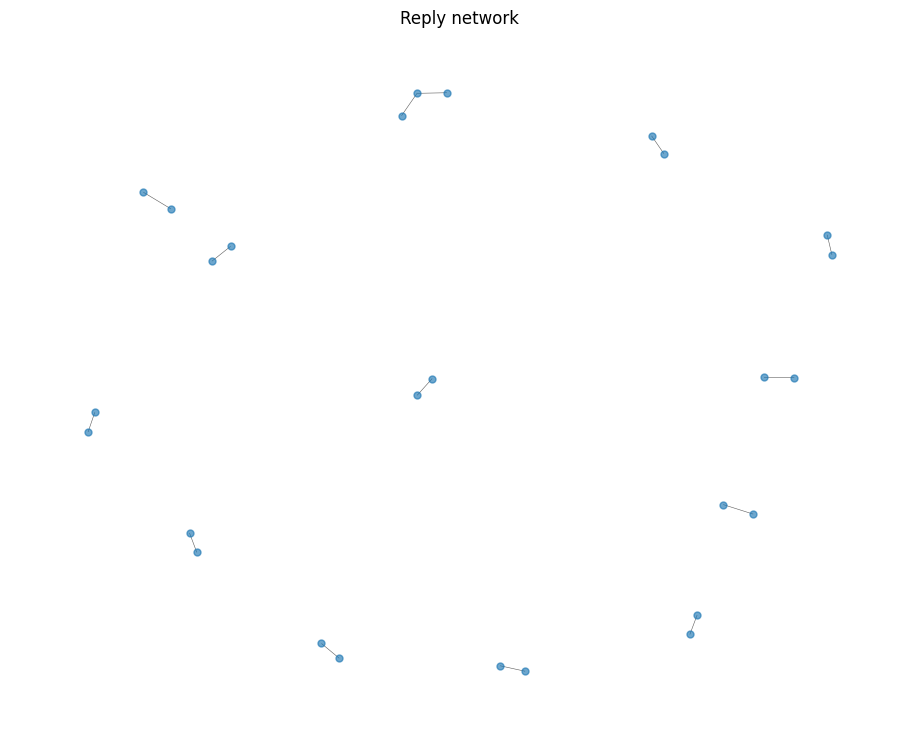

mention: nodes=219, edges=179


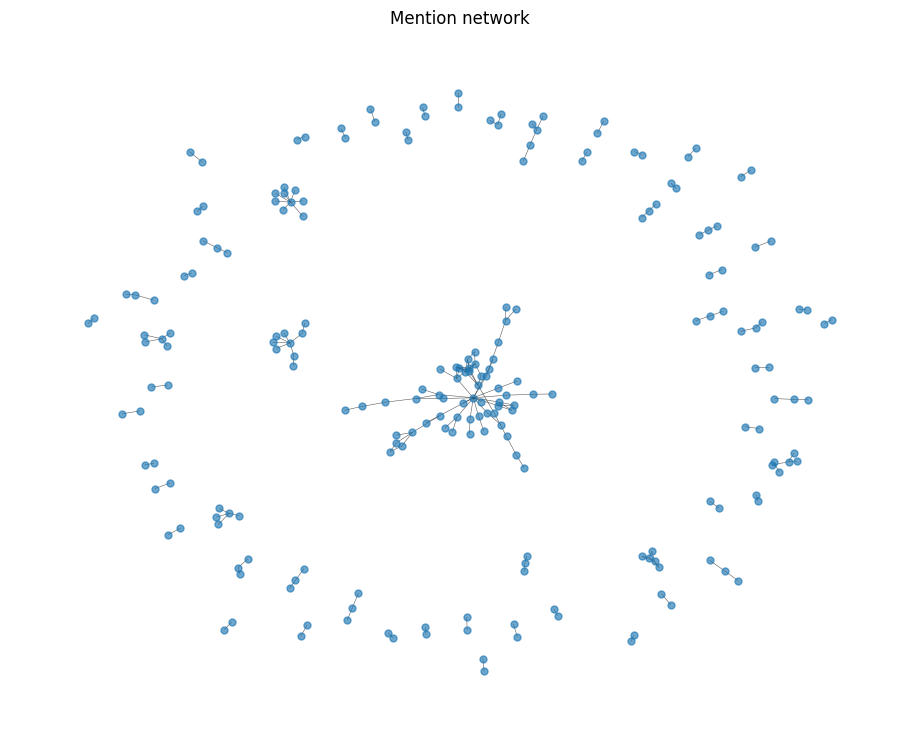

In [71]:
import os, pandas as pd, networkx as nx, matplotlib.pyplot as plt
PROC_DIR, FIG_DIR = "data_processed", "figures"
os.makedirs(FIG_DIR, exist_ok=True)
edges = pd.read_csv(os.path.join(PROC_DIR,"edges.csv"), dtype=str)

for etype in ["retweet","reply","mention"]:
    e = edges[edges["edge_type"]==etype]
    Gt = nx.from_pandas_edgelist(e, "source","target", create_using=nx.DiGraph())
    print(f"{etype}: nodes={Gt.number_of_nodes()}, edges={Gt.number_of_edges()}")
    U = Gt.to_undirected()
    if U.number_of_nodes()==0: continue
    pos = nx.spring_layout(U, seed=42)
    plt.figure(figsize=(9,7))
    nx.draw(U, pos, node_size=25, alpha=0.65, width=0.4)
    plt.title(f"{etype.capitalize()} network"); plt.axis("off"); plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, f"{etype}_network.png"), dpi=160); plt.show()


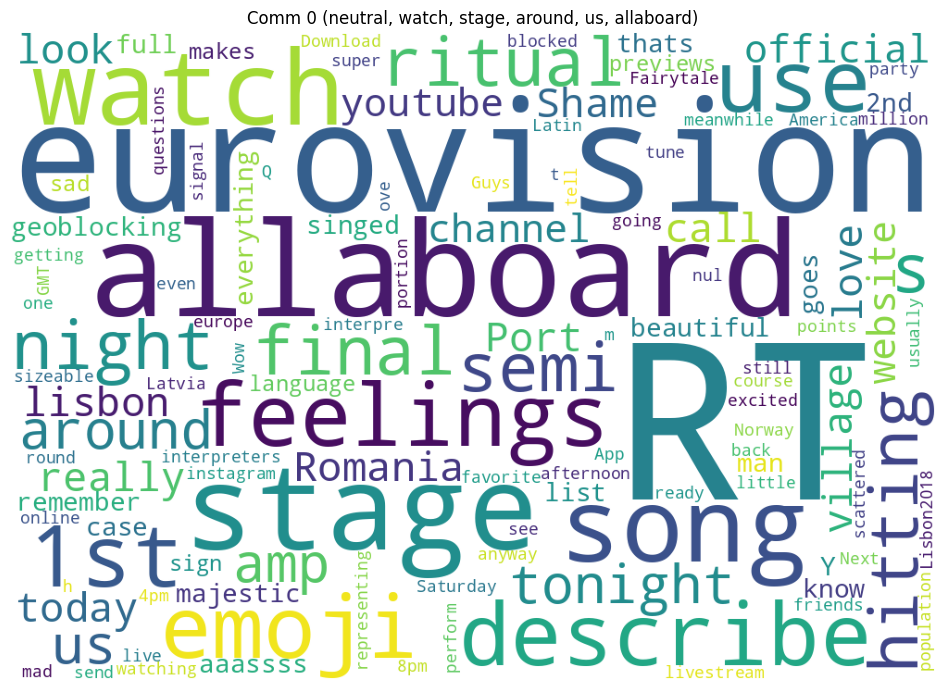

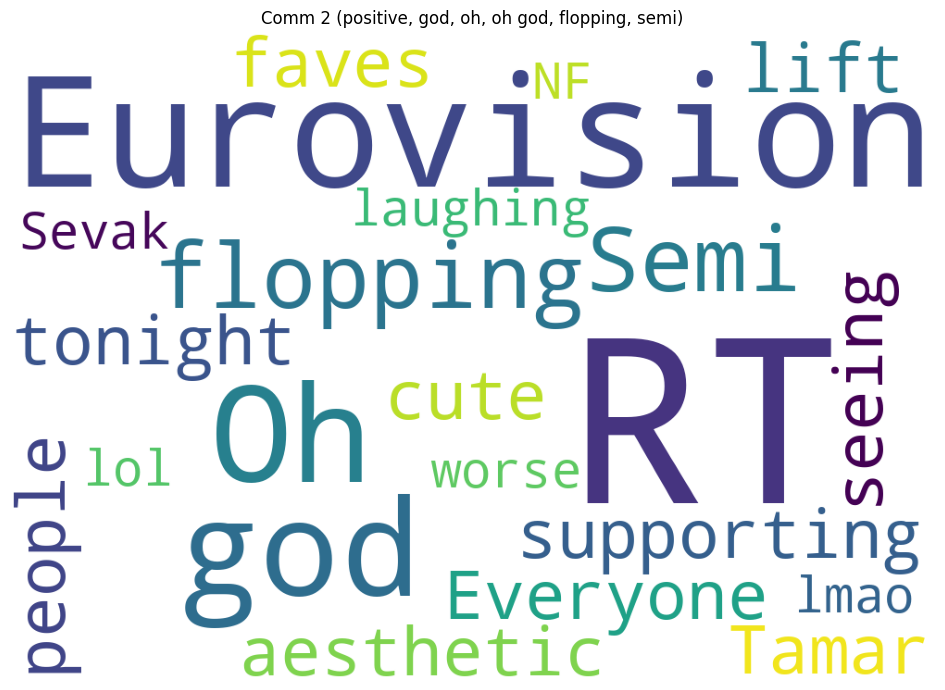

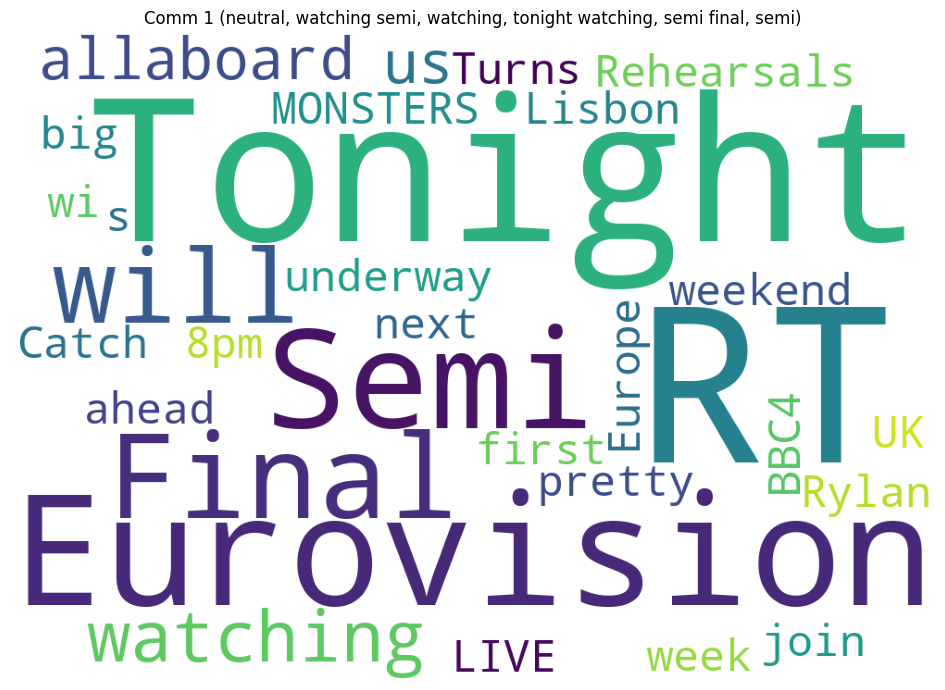

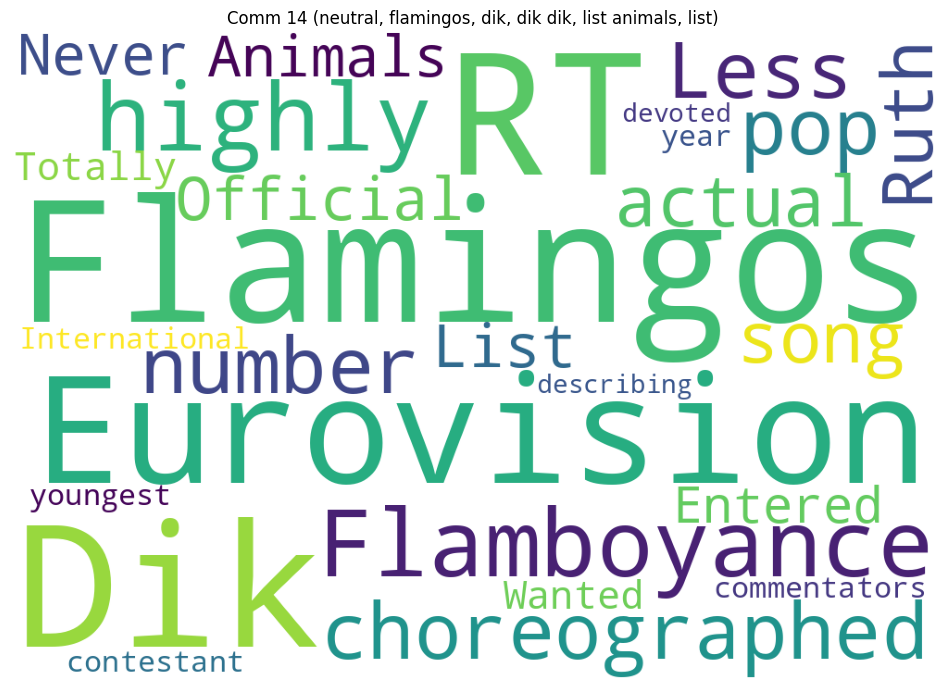

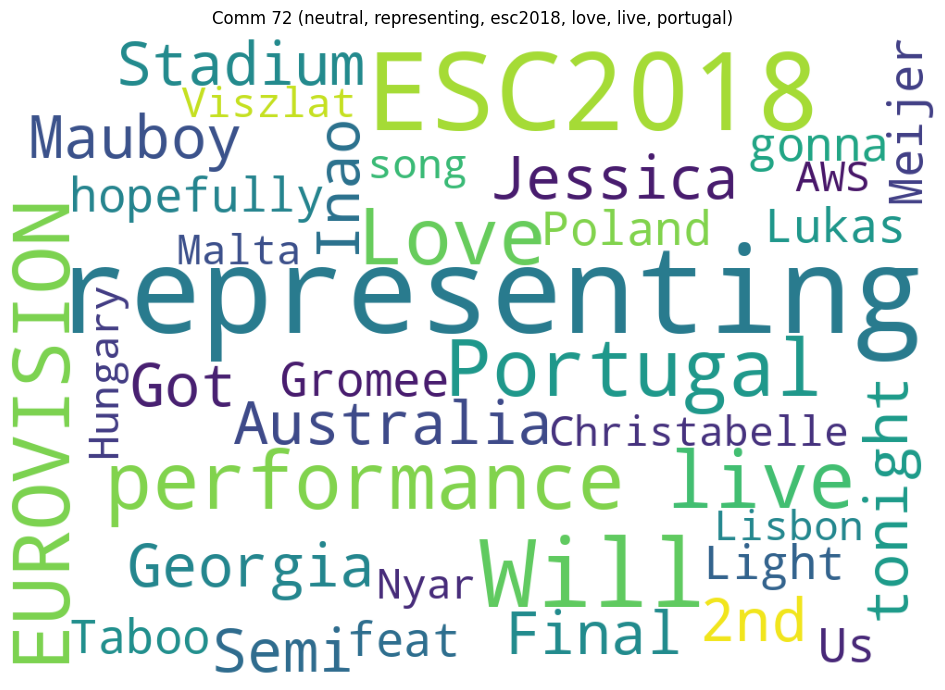

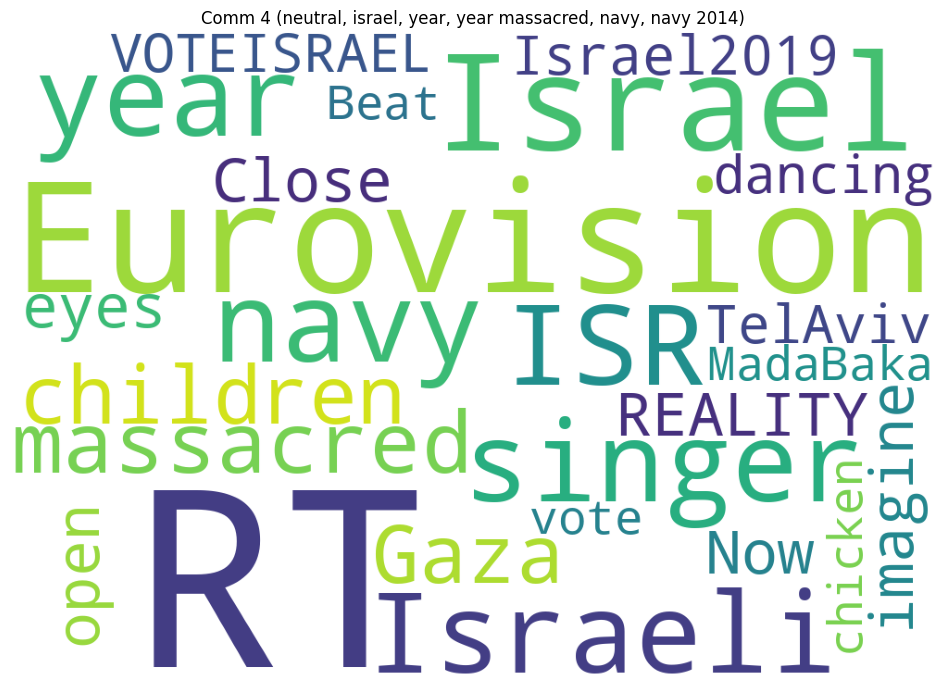

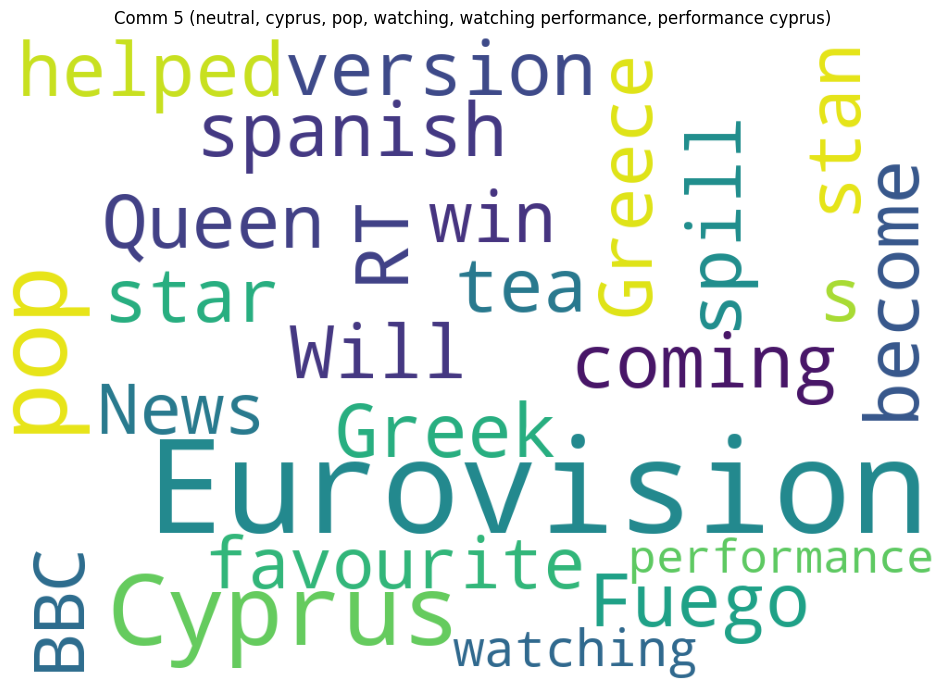

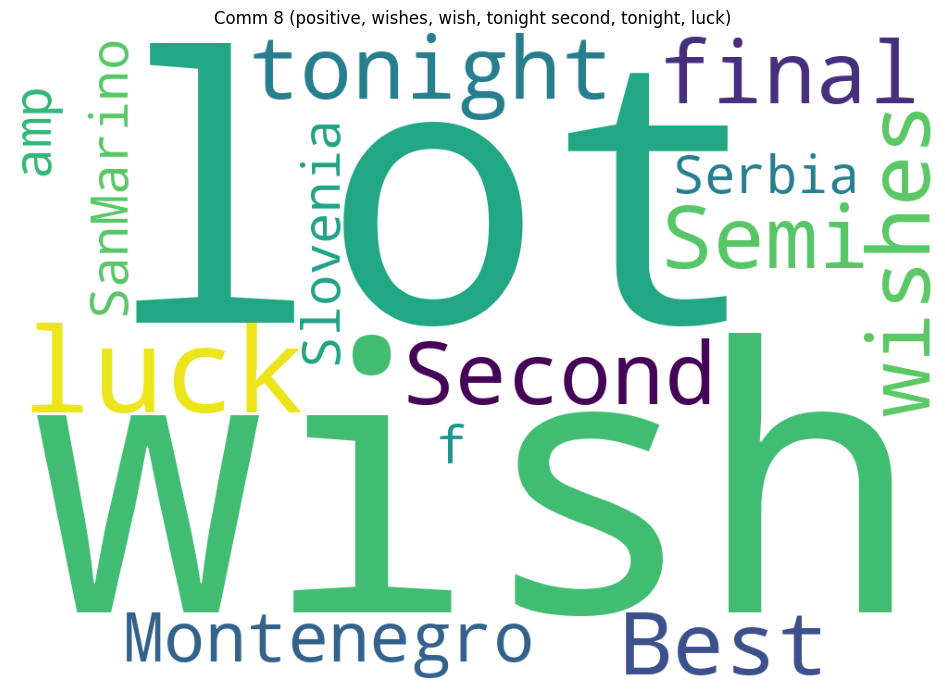

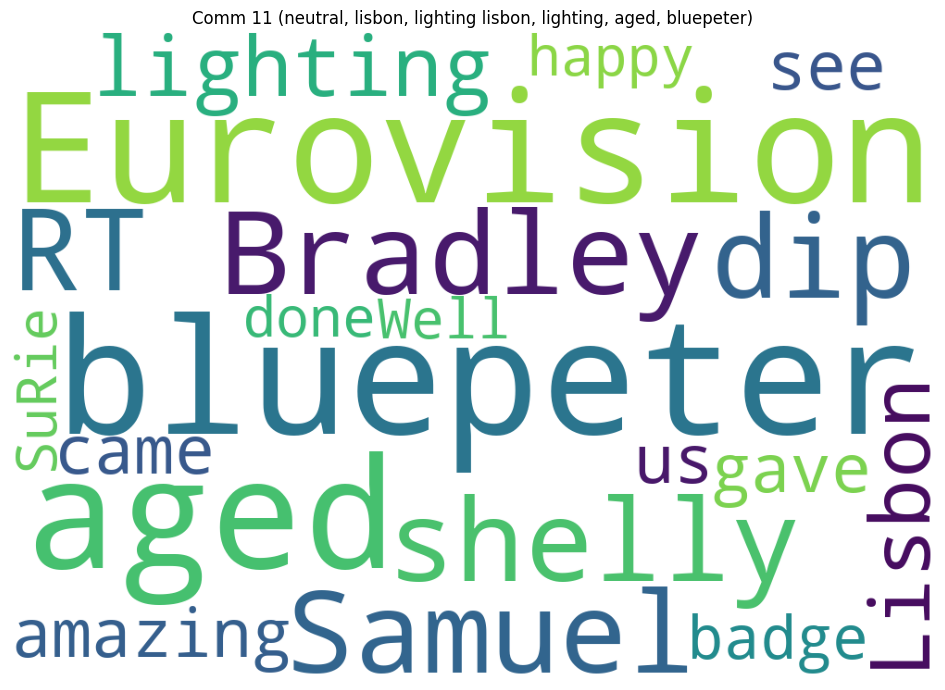

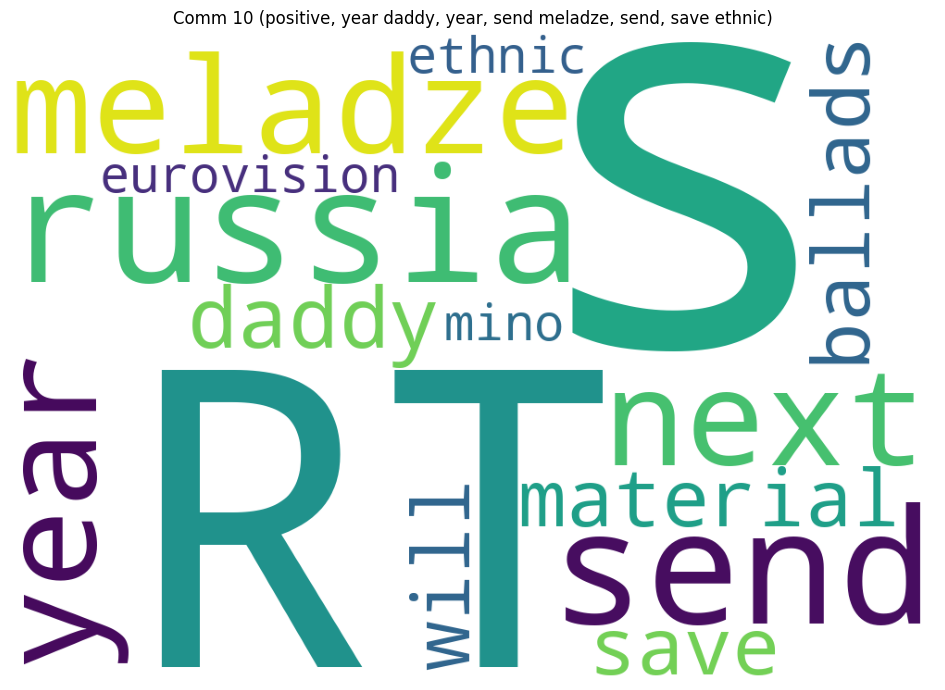

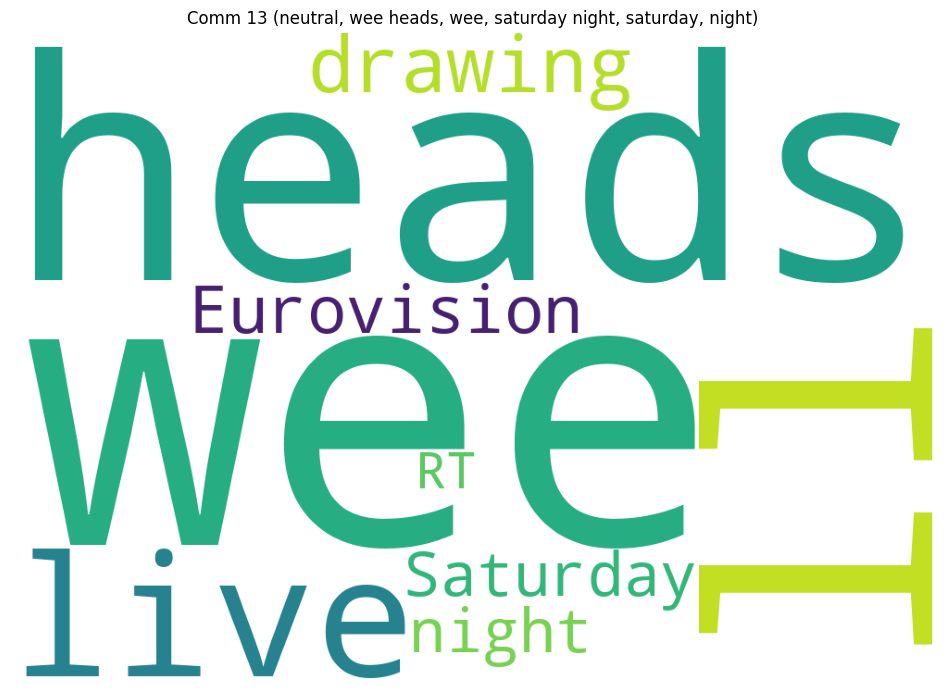

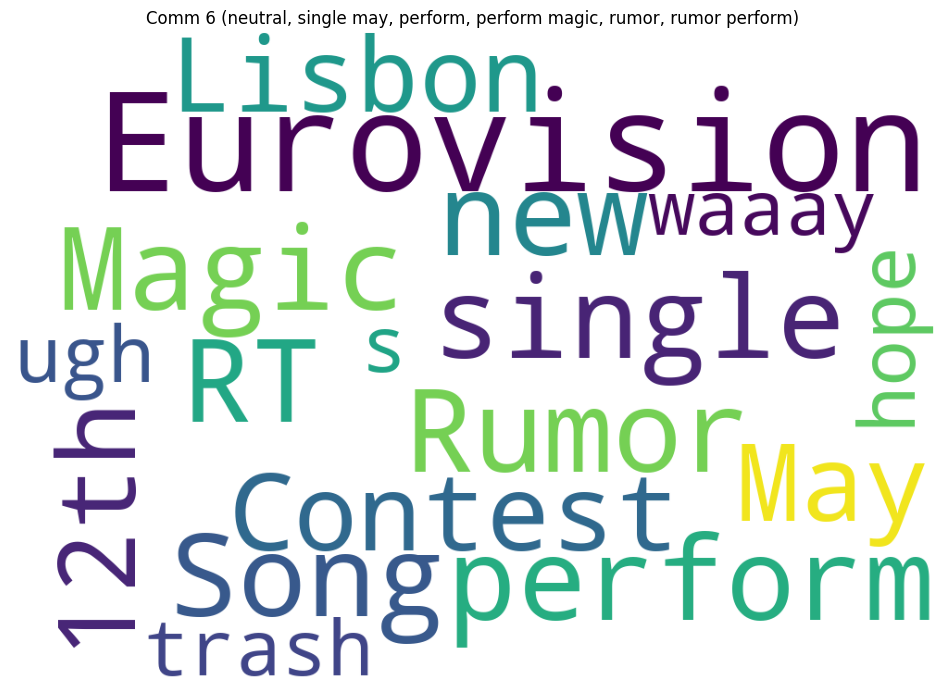

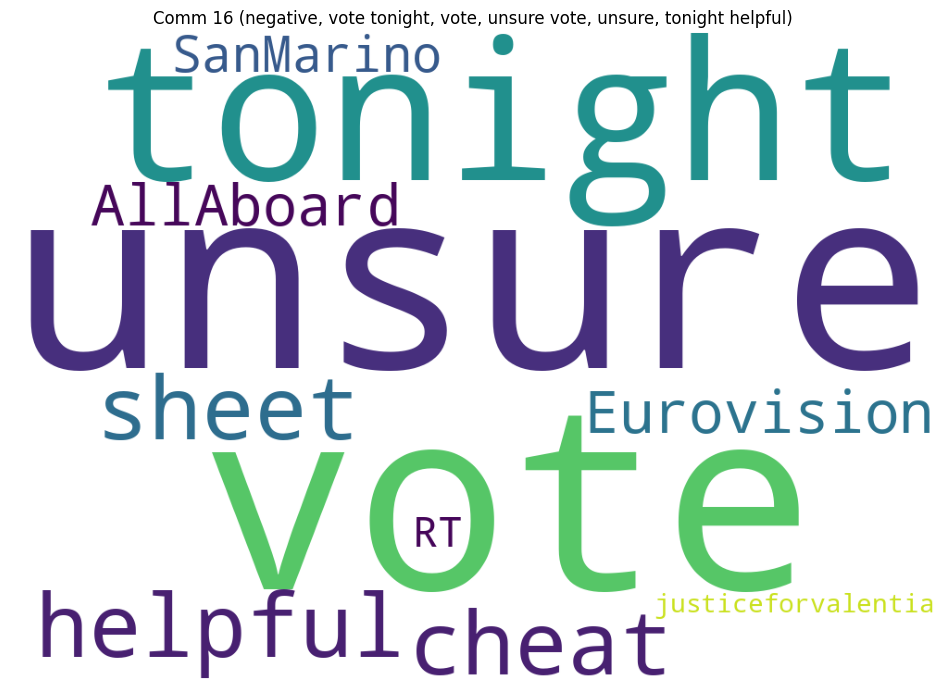

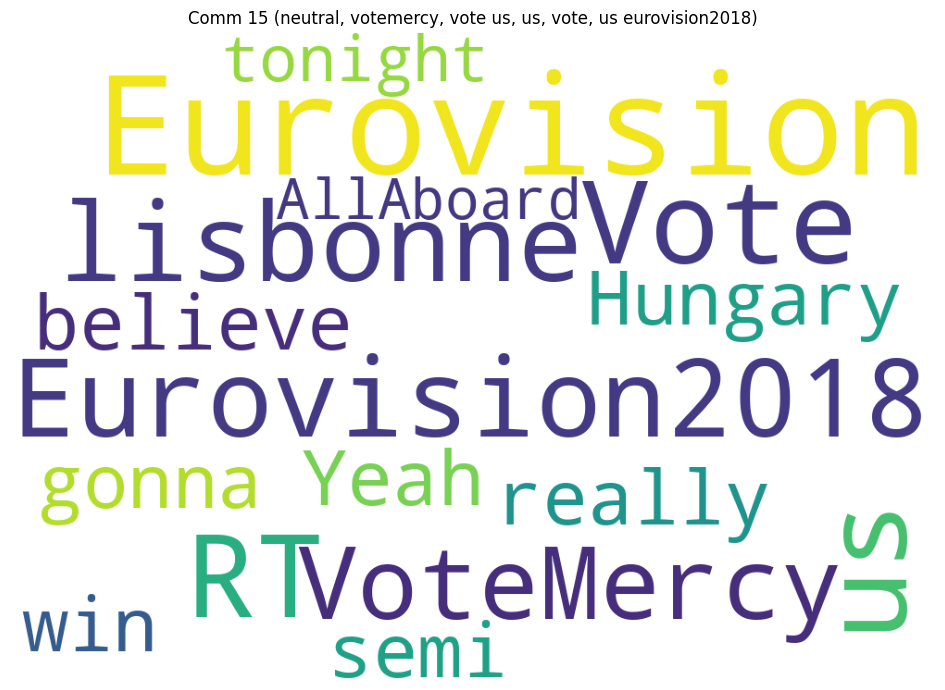

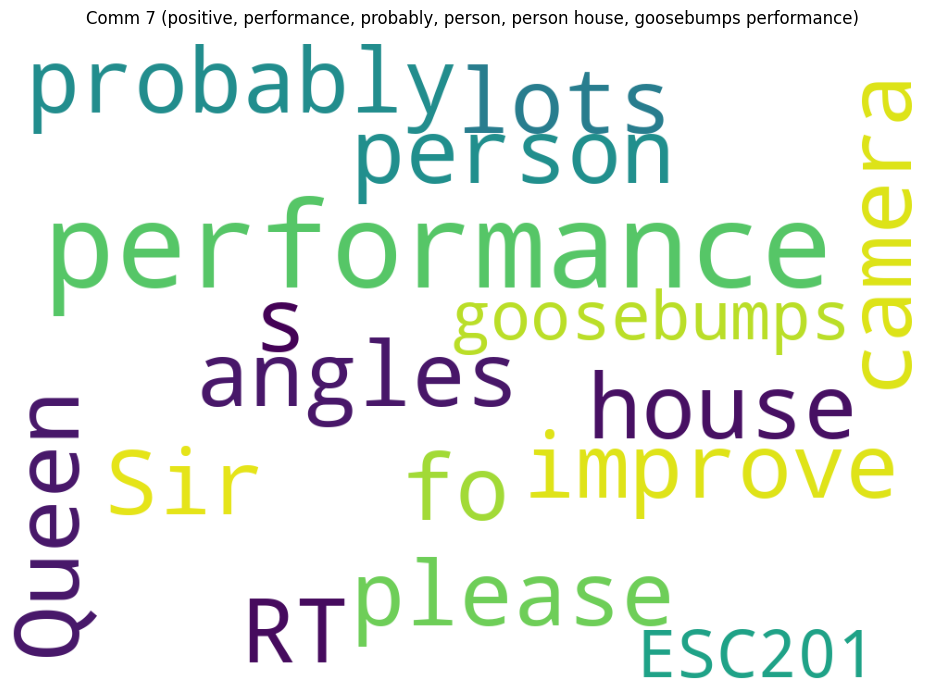

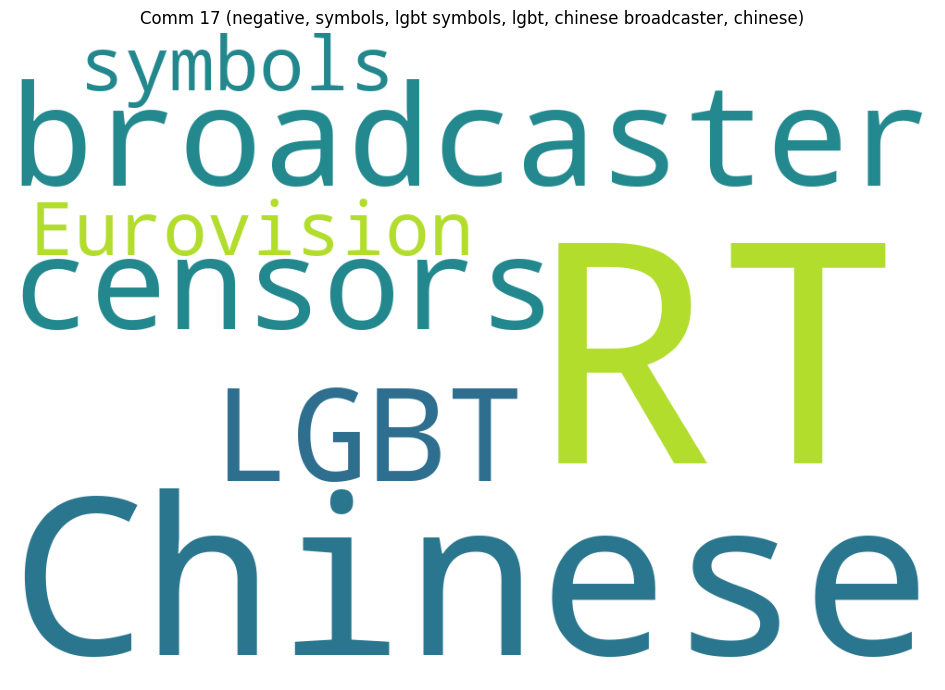

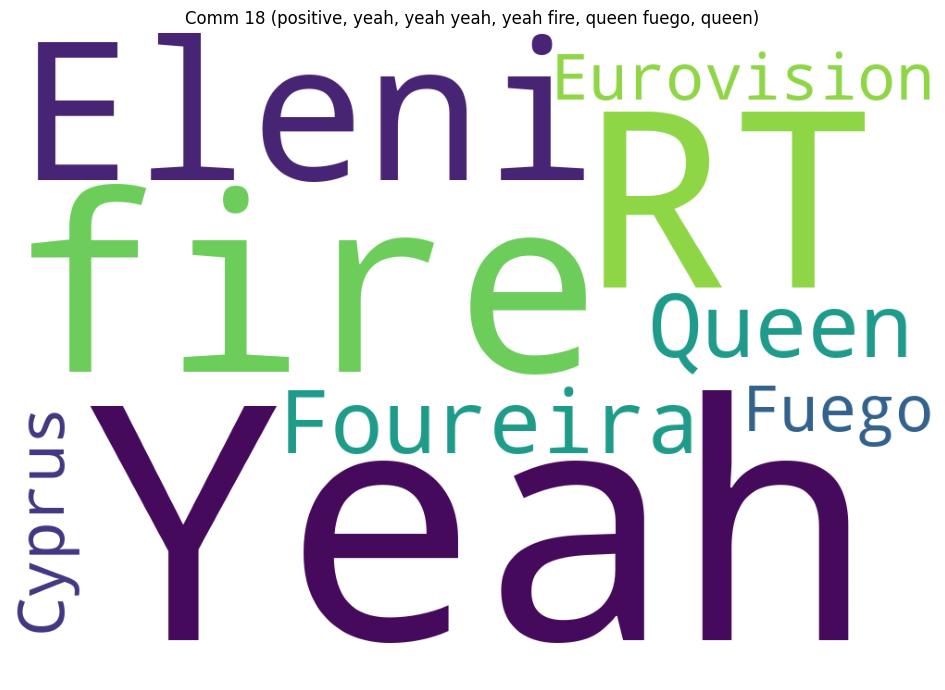

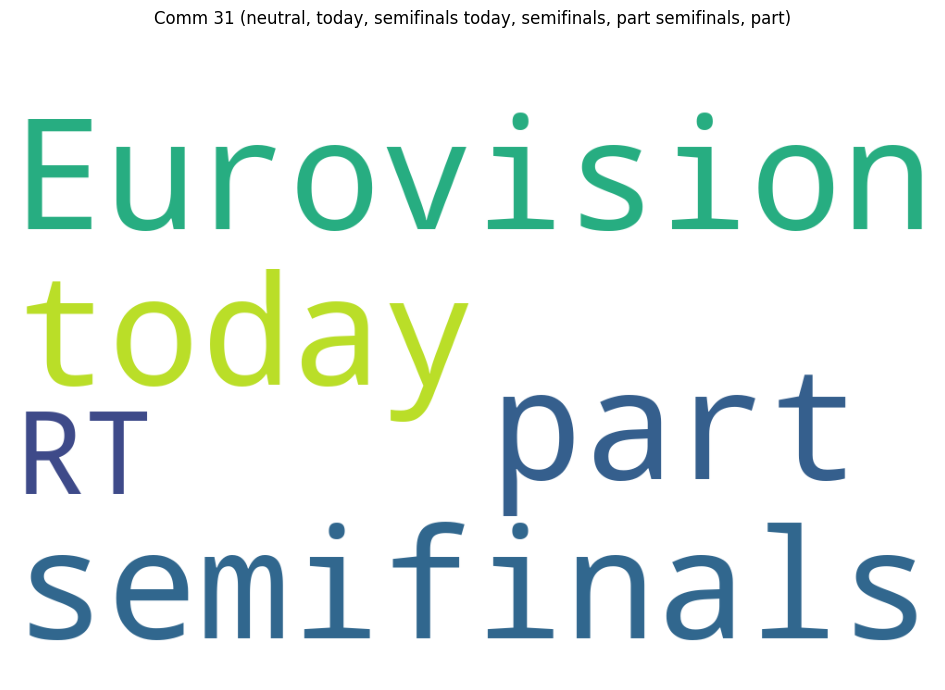

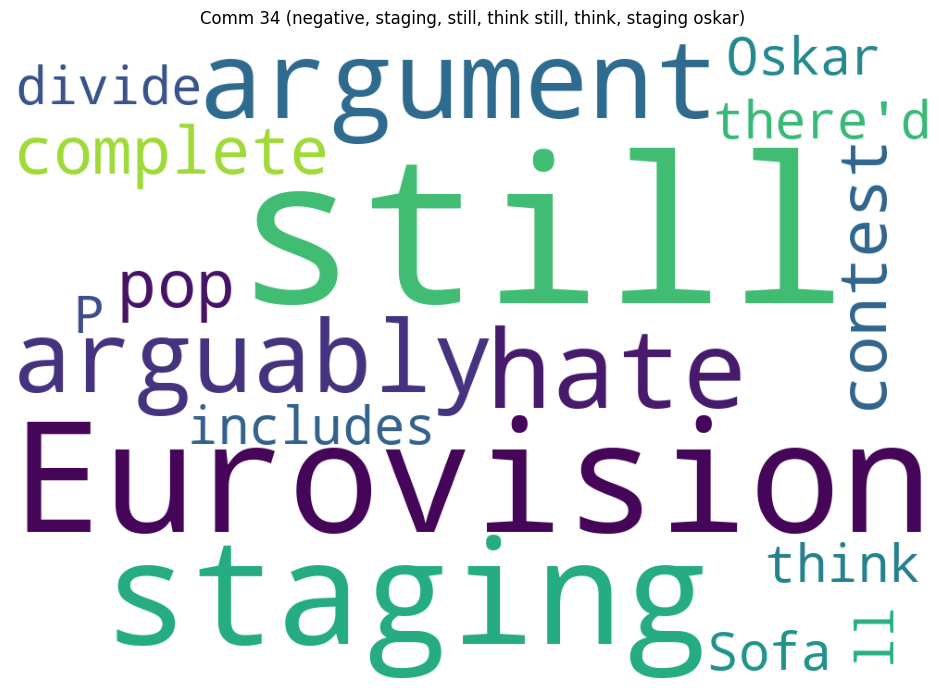

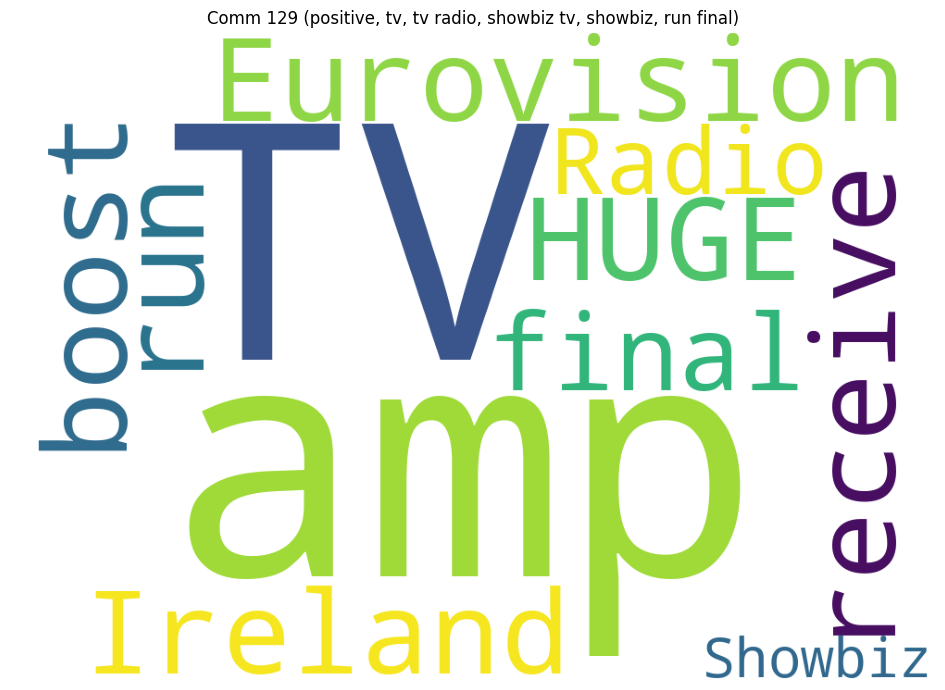

In [72]:
!pip -q install wordcloud
from wordcloud import WordCloud
import os, pandas as pd, matplotlib.pyplot as plt

PROC_DIR, FIG_DIR = "data_processed", "figures"
tweets = pd.read_parquet(os.path.join(PROC_DIR,"tweets_en_with_community.parquet"))
labels_df = pd.read_csv(os.path.join(PROC_DIR,"community_labels_top20.csv"))  # TOP_K=20 iz 04C

for cid, label in zip(labels_df["community"], labels_df["label"]):
    text = " ".join(tweets.loc[tweets["community"]==cid,"clean_text"].dropna())
    if not text.strip(): continue
    wc = WordCloud(width=1000, height=700, background_color="white").generate(text)
    plt.figure(figsize=(10,7)); plt.imshow(wc); plt.axis("off"); plt.title(label); plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, f"wordcloud_comm_{cid}.png"), dpi=160); plt.show()



TOP 5 FAN zajednica (share pozitivnih, total >= 3):
 community                                                                 label  total  positive_pct  compound_mean
         2                    Comm 2 (positive, god, oh, oh god, flopping, semi)      8           1.0          0.394
        10 Comm 10 (positive, year daddy, year, send meladze, send, save ethnic)      3           1.0          0.494
         8        Comm 8 (positive, wishes, wish, tonight second, tonight, luck)      3           1.0          0.888
        14        Comm 14 (neutral, flamingos, dik, dik dik, list animals, list)      5           0.4          0.130
        72        Comm 72 (neutral, representing, esc2018, love, live, portugal)      5           0.4          0.251

TOP 5 HEJT zajednica (share negativnih, total >= 3):
 community                                                                         label  total  negative_pct  compound_mean
        16  Comm 16 (negative, vote tonight, vote, unsure vote, un

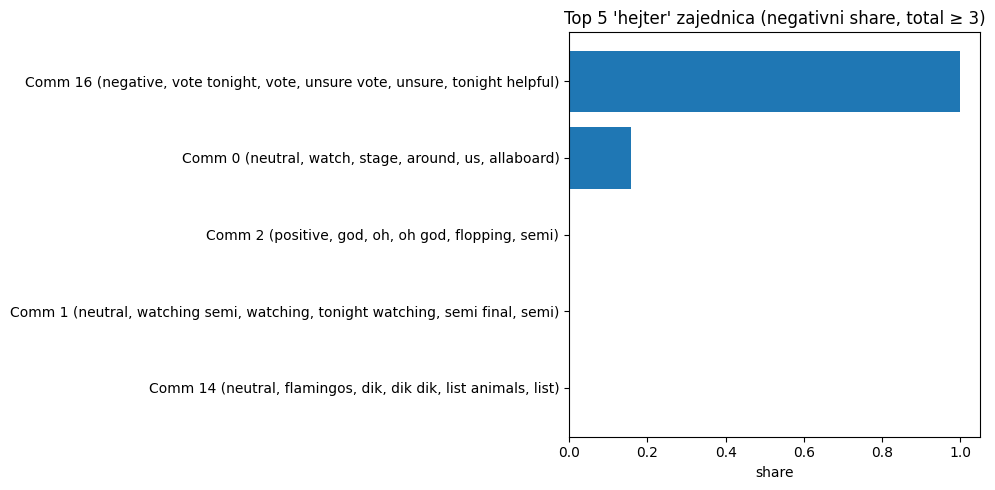

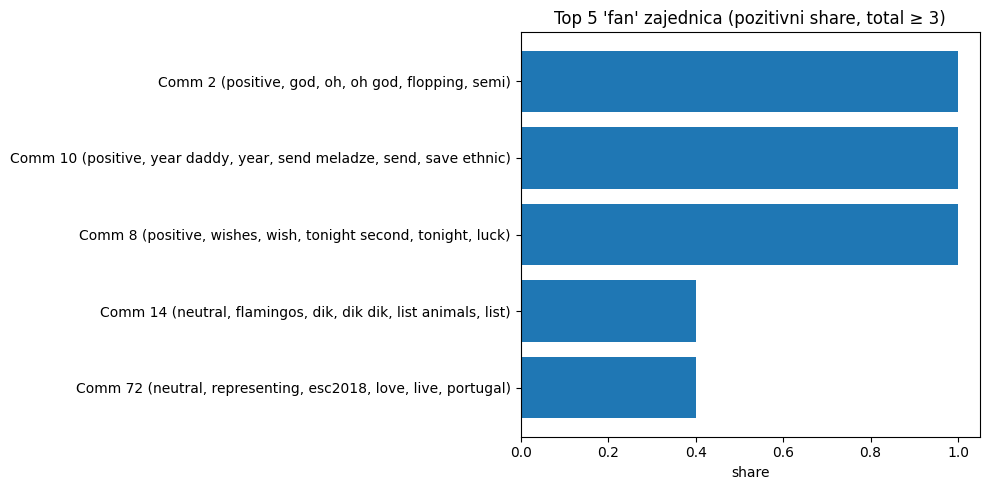

✔ 10 (relevant communities) – gotov.


In [73]:
# === 10_haters_vs_fans_by_community_relevant.py ===
import os, pandas as pd, matplotlib.pyplot as plt

PROC_DIR, FIG_DIR = "data_processed", "figures"
os.makedirs(FIG_DIR, exist_ok=True)

# ---- parametri za "relevantnost" zajednice ----
MIN_TOTAL = 3      # minimalno tvitova u zajednici da bi ušla u rang listu
TOP_N = 5         # koliko zajednica prikazati

sum_path = os.path.join(PROC_DIR, "sentiment_summary_by_community.csv")
labs_path = os.path.join(PROC_DIR, "community_labels_top20.csv")  # iz 04C (može i drugi TOP_K fajl)

if not os.path.exists(sum_path):
    raise FileNotFoundError("Nema data_processed/sentiment_summary_by_community.csv – pokreni 04/04C.")

# 1) učitaj rezime po zajednicama
comm = pd.read_csv(sum_path)

# 2) pridruži labele (ako postoje)
if os.path.exists(labs_path):
    labs = pd.read_csv(labs_path)
    comm = comm.merge(labs[["community","label"]], on="community", how="left")
else:
    comm["label"] = pd.NA

# 3) popuni prazne labele i tipovi
comm["label"] = comm.apply(
    lambda r: r["label"] if isinstance(r["label"], str) and r["label"].strip()
              else f"Comm {int(r['community'])}" if pd.notna(r["community"]) else "Comm ?",
    axis=1
).astype(str)

for col in ["negative_pct","positive_pct","neutral_pct","total","compound_mean"]:
    if col in comm.columns:
        comm[col] = pd.to_numeric(comm[col], errors="coerce")

# 4) filtriraj na "relevantne" zajednice (po obimu)
comm_rel = comm[comm["total"] >= MIN_TOTAL].copy()
if comm_rel.empty:
    print(f"Nema zajednica sa total >= {MIN_TOTAL}. Smanji MIN_TOTAL ili proveri 04C.")
else:
    # rang liste
    fans = comm_rel.sort_values(["positive_pct","total"], ascending=[False,False]) \
                   .head(TOP_N)[["community","label","total","positive_pct","compound_mean"]]
    haters = comm_rel.sort_values(["negative_pct","total"], ascending=[False,False]) \
                     .head(TOP_N)[["community","label","total","negative_pct","compound_mean"]]

    print(f"\nTOP {TOP_N} FAN zajednica (share pozitivnih, total >= {MIN_TOTAL}):")
    print(fans.to_string(index=False))
    print(f"\nTOP {TOP_N} HEJT zajednica (share negativnih, total >= {MIN_TOTAL}):")
    print(haters.to_string(index=False))

    # --- graf: hejteri ---
    h = haters.copy()
    plt.figure(figsize=(10,5))
    plt.barh(h["label"].astype(str).iloc[::-1], h["negative_pct"].astype(float).iloc[::-1])
    plt.title(f"Top {TOP_N} 'hejter' zajednica (negativni share, total ≥ {MIN_TOTAL})")
    plt.xlabel("share"); plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, f"top_hater_communities_min{MIN_TOTAL}.png"), dpi=160)
    plt.show()

    # --- graf: fanovi ---
    f = fans.copy()
    plt.figure(figsize=(10,5))
    plt.barh(f["label"].astype(str).iloc[::-1], f["positive_pct"].astype(float).iloc[::-1])
    plt.title(f"Top {TOP_N} 'fan' zajednica (pozitivni share, total ≥ {MIN_TOTAL})")
    plt.xlabel("share"); plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, f"top_fan_communities_min{MIN_TOTAL}.png"), dpi=160)
    plt.show()

print("✔ 10 (relevant communities) – gotov.")




✔ Sačuvan izveštaj: data_processed/central_actors_report.csv


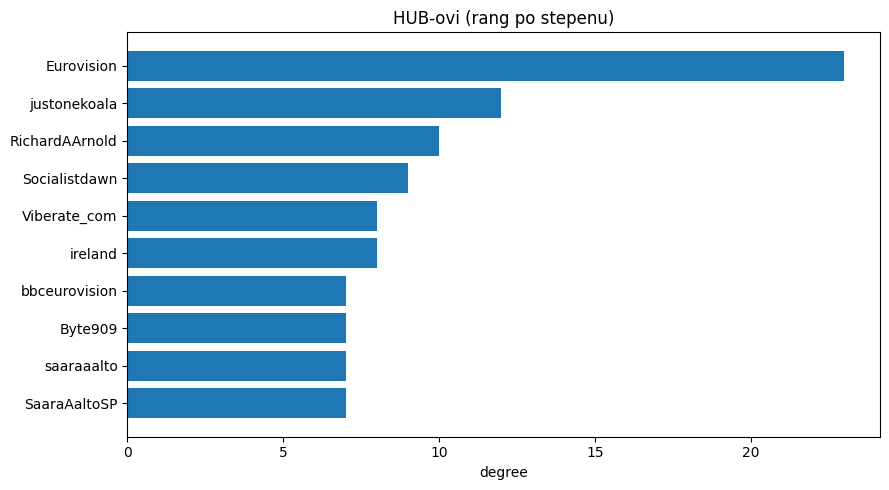

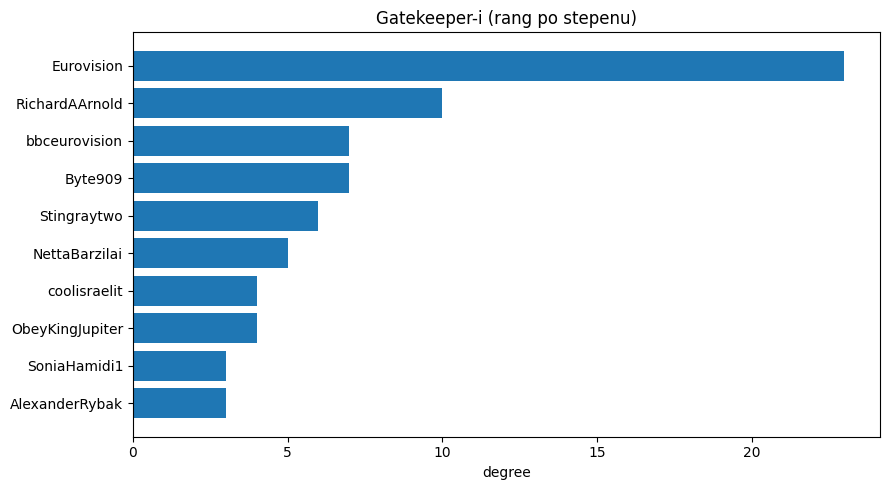

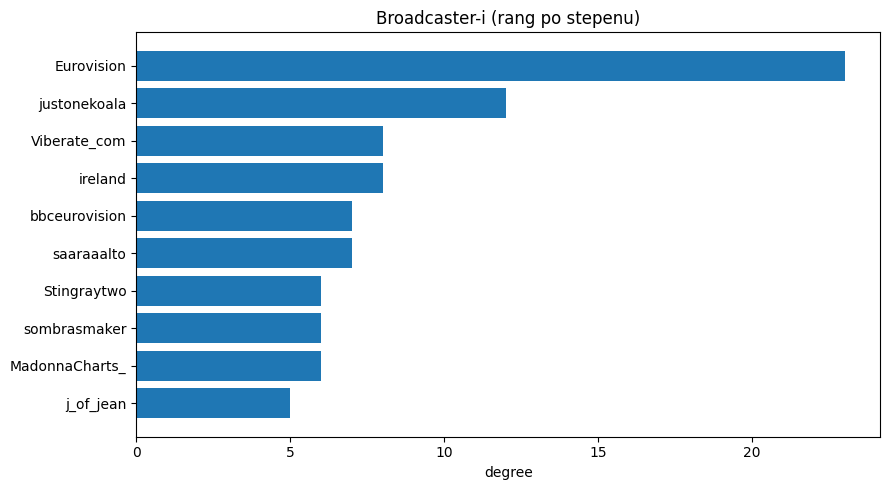

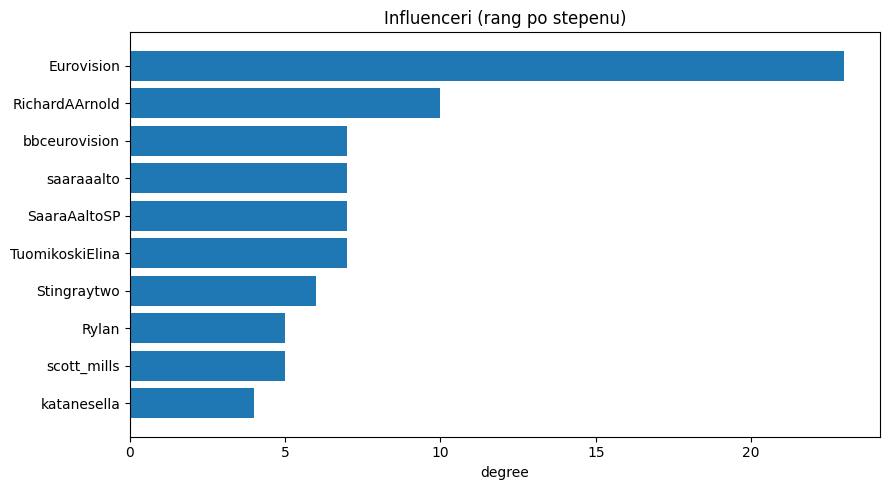

(nema kandidata: Fan nalozi)
(nema kandidata: Hejt nalozi)
(nema kandidata: Potencijalni trolovi)
✔ Grafici su u 'figures/'


In [74]:
# === 12_identify_central_actors_fallback.py (robust fix) ===
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
import networkx as nx

PROC_DIR, FIG_DIR = "data_processed", "figures"
os.makedirs(PROC_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)

# ---------- učitaj osnovu ----------
edges = pd.read_csv(os.path.join(PROC_DIR, "edges.csv"), dtype=str)
nodes = pd.read_csv(os.path.join(PROC_DIR, "nodes.csv"), dtype=str)

um_path = os.path.join(PROC_DIR, "user_metrics.csv")
if os.path.exists(um_path):
    users = pd.read_csv(um_path)
else:
    # napravi minimalne metrike iz nodes/edges
    e = edges.copy()
    out_deg = e.groupby("source").size().rename("out_degree")
    in_deg  = e.groupby("target").size().rename("in_degree")
    deg = (out_deg.add(in_deg, fill_value=0)).rename("deg")
    rt_sent = e[e.edge_type=="retweet"].groupby("source").size().rename("retweets_sent")
    rt_recv = e[e.edge_type=="retweet"].groupby("target").size().rename("retweets_received")
    rp_sent = e[e.edge_type=="reply"].groupby("source").size().rename("replies_sent")
    rp_recv = e[e.edge_type=="reply"].groupby("target").size().rename("replies_received")
    mn_sent = e[e.edge_type=="mention"].groupby("source").size().rename("mentions_sent")
    mn_recv = e[e.edge_type=="mention"].groupby("target").size().rename("mentions_received")

    users = (pd.DataFrame({"username": nodes["node_id"]})
               .drop_duplicates().set_index("username"))
    for s in [out_deg,in_deg,deg,rt_sent,rt_recv,rp_sent,rp_recv,mn_sent,mn_recv]:
        users = users.join(s, how="left")
    users = users.fillna(0).reset_index()
    # placeholderi da kasnije ne pucamo
    for col in ["tweets","betweenness","closeness","community",
                "positive_pct","negative_pct","compound_mean","total"]:
        if col not in users.columns:
            users[col] = 0

# ---------- centralnosti iz grafa ----------
G  = nx.from_pandas_edgelist(edges, "source", "target", create_using=nx.DiGraph())
UG = G.to_undirected()

if users.get("betweenness", pd.Series([0])).sum() == 0:
    btw = nx.betweenness_centrality(UG, normalized=True) if UG.number_of_nodes() else {}
    users["betweenness"] = users["username"].map(lambda u: btw.get(u, 0.0))

if users.get("closeness", pd.Series([0])).sum() == 0 and UG.number_of_nodes() > 0:
    giant = max(nx.connected_components(UG), key=len)
    H = UG.subgraph(giant).copy()
    clos = nx.closeness_centrality(H)
    users["closeness"] = users["username"].map(lambda u: clos.get(u, 0.0))

if UG.number_of_nodes() > 0:
    giant = max(nx.connected_components(UG), key=len)
    H = UG.subgraph(giant).copy()
    eig = nx.eigenvector_centrality_numpy(H)
    users["eigenvector"] = users["username"].map(lambda u: eig.get(u, 0.0))
else:
    users["eigenvector"] = 0.0

# ---------- sentiment po korisniku (ako postoji fajl) ----------
sent_path = os.path.join(PROC_DIR, "sentiment_by_community.csv")
if os.path.exists(sent_path):
    s = pd.read_csv(sent_path, dtype={"username":str})
    s["pos_f"] = (s["sentiment"]=="positive").astype(int)
    s["neg_f"] = (s["sentiment"]=="negative").astype(int)
    agg = (s.groupby("username")[["pos_f","neg_f","compound"]]
             .agg(pos=("pos_f","sum"),
                  neg=("neg_f","sum"),
                  compound_mean=("compound","mean"),
                  total=("pos_f","size"))
             .reset_index())
    agg["positive_pct"] = agg["pos"]/agg["total"]
    agg["negative_pct"] = agg["neg"]/agg["total"]
    users = users.merge(
        agg[["username","positive_pct","negative_pct","compound_mean","total"]],
        on="username", how="left"
    )

# >>> robustno osiguraj kolone, pa tek onda fillna <<<
for col in ["positive_pct","negative_pct","compound_mean","total"]:
    if col not in users.columns:
        users[col] = 0.0
users[["positive_pct","negative_pct","compound_mean","total"]] = \
    users[["positive_pct","negative_pct","compound_mean","total"]].fillna(0)

# ---------- uloge ----------
def top_mask(series, q=0.95):
    if series.empty:
        return pd.Series([False]*len(series))
    thr = series.quantile(q)
    return series >= thr

roles = []
for i, r in users.iterrows():
    tags = []
    if top_mask(users["deg"]).iloc[i] or top_mask(users["out_degree"]).iloc[i]:
        tags.append("hub")
    if top_mask(users["betweenness"]).iloc[i]:
        tags.append("gatekeeper")
    if top_mask(users["closeness"]).iloc[i] or top_mask(users["retweets_received"]).iloc[i]:
        tags.append("broadcaster")
    if top_mask(users["eigenvector"]).iloc[i]:
        tags.append("influencer")
    if r["positive_pct"] >= 0.60 and r["total"] >= 3:
        tags.append("fan")
    if r["negative_pct"] >= 0.60 and r["total"] >= 3:
        tags.append("hater")
    if (r["out_degree"] >= np.percentile(users["out_degree"],95) and
        r["negative_pct"] >= 0.6 and
        (r.get("replies_received",0)+r.get("retweets_received",0)) <= 1):
        tags.append("potential_troll")
    roles.append(",".join(tags) if tags else "regular")
users["roles"] = roles

# ---------- izvoz + grafici ----------
cols = ["username","tweets","out_degree","in_degree","deg",
        "betweenness","closeness","eigenvector",
        "retweets_sent","retweets_received","replies_sent","replies_received",
        "mentions_sent","mentions_received",
        "positive_pct","negative_pct","compound_mean","total","roles"]
for c in cols:
    if c not in users.columns: users[c] = 0

users[cols].to_csv(os.path.join(PROC_DIR, "central_actors_report.csv"), index=False)
print("✔ Sačuvan izveštaj: data_processed/central_actors_report.csv")

def plot_top(mask, title, file):
    d = users[mask].sort_values(["deg","betweenness"], ascending=False).head(10)
    if d.empty:
        print(f"(nema kandidata: {title})"); return
    plt.figure(figsize=(9,5))
    plt.barh(d["username"][::-1], d["deg"][::-1])
    plt.title(title+" (rang po stepenu)"); plt.xlabel("degree")
    plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, file), dpi=160); plt.show()

plot_top(users["roles"].str.contains("hub"),            "HUB-ovi",              "central_hubs.png")
plot_top(users["roles"].str.contains("gatekeeper"),     "Gatekeeper-i",         "central_gatekeepers.png")
plot_top(users["roles"].str.contains("broadcaster"),    "Broadcaster-i",        "central_broadcasters.png")
plot_top(users["roles"].str.contains("influencer"),     "Influenceri",          "central_influencers.png")
plot_top(users["roles"].str.contains("fan"),            "Fan nalozi",           "central_fans.png")
plot_top(users["roles"].str.contains("hater"),          "Hejt nalozi",          "central_haters.png")
plot_top(users["roles"].str.contains("potential_troll"),"Potencijalni trolovi", "central_trolls.png")

print("✔ Grafici su u 'figures/'")


